# QA solid solutions

- [Multiplicity](#multiplicity)
- [Build the structures](#structures)
- [Build the test/train set](#manual_confcount)
- [Build the QUBO model](#ml_energies)
- [Graphene Exhaustive Search](#graphene_es)
- [Run the anneal](#anneal_binary)
    - [GaAlN](#anneal_binary_gaaln) 
    - [WMo](#anneal_binary_wmo) 
- [Test QUBO classical](#test_QUBO_classical)
- [Experiments](#experiments)

In [5]:
import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/UCL/quantum_computing')
from quantum_computing_functions import * # type: ignore
from quantum_computing_postprocessing import *
from symmetry_functions import *
from QA_disordered_systems_functions import *

from dwave.embedding.chain_strength import  uniform_torque_compensation

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.vasp import *

from ase.visualize import view

from pymatgen.ext.matproj import MPRester

from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import sys
# sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
# from crystal_io import *
# from convert import *
import re
import shutil as sh

from CRYSTALpytools.crystal_io import * 
from CRYSTALpytools.convert import * 

import copy
from sklearn.metrics import mean_squared_error 

import dataframe_image as dfi
#from dscribe.descriptors import CoulombMatrix
from scipy import constants

import matplotlib.pyplot as plt

import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

from dwave.system import EmbeddingComposite, DWaveSampler
import dimod 

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
# print(k_b)
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

import seaborn as sns

In [6]:
import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
from crystal_io import *
from convert import *

ModuleNotFoundError: No module named 'CRYSTALpytools.base.propd3'

def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels.
        multiplicity (np.ndarray): Array of corresponding multiplicities.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Flag to return probabilities. Default is True.
        N_N (float, optional): Number of N particles. Default is 0.
        N_potential (float, optional): Potential for N particles. Default is 0.

    Returns:
        tuple or float: If return_pi is True, returns a tuple containing partition function and probabilities.
                        Otherwise, returns the partition function.
    """
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K
    
    energy = np.array(energy)
    multiplicity = np.array(multiplicity)
    p_i = multiplicity * np.exp((-energy + (N_N * N_potential)) / (k_b * T))
    
    pf = np.sum(p_i)
    
    p_i /= pf
    
    if return_pi:
        return pf, p_i
    else:
        return pf

def generate_symm_irr_structures(gui_object, output_object, new_atom, atom_type1 = False):
    """
    Generate symmetrically-irreducible structures with atom substitutions.

    Args:
        gui_object: The GUI object.
        output_object: The output object.
        new_atom: The new atom to substitute.

    Returns:
        List of generated structures.
    """
    output_object.get_config_analysis(return_multiplicity=True)
    original_structure = cry_gui2pmg(gui_object)
    multiplicity = output_object.multiplicity
    structures = []

    if atom_type1 == False:
        for substitutions in output_object.atom_type2:
            new_structure = original_structure.copy()
            for i in substitutions:
                new_structure.replace(i - 1, new_atom)
            structures.append(new_structure)
    else:
        for substitutions in output_object.atom_type1:
            new_structure = original_structure.copy()
            for i in substitutions:
                new_structure.replace(i - 1, new_atom)
            structures.append(new_structure)
    

    return structures, multiplicity

#THIS WORKS WITH CRYSTAL
def get_all_configurations(gui_object):

    symmops = np.array(gui_object.symmops)
    coordinates = np.array(gui_object.atom_positions)
    n_symmops = gui_object.n_symmops
    atom_numbers = np.array(gui_object.atom_number)
    lattice = gui_object.lattice
    
    original_structure = Structure(lattice,atom_numbers,coordinates,coords_are_cartesian=True)

        
        
    rotations = []
    translation = []
    for symmop in symmops:
        rotations.append(symmop[0:3])
        translation.append(symmop[3:4])
    atom_indices = []
    structures = []
    for i in range(n_symmops):
        atom_indices_tmp = []
        coordinates_new = np.matmul(coordinates,rotations[i])+np.tile(translation[i], (len(atom_numbers),1))

        #lattice_new = np.matmul(lattice,rotations[i])+np.tile(translation[i], (3,1))
        structure_tmp = Structure(lattice,atom_numbers,coordinates_new,coords_are_cartesian=True)
        for k,coord in enumerate(original_structure.frac_coords):
            structure_tmp.append(original_structure.atomic_numbers[k],coord,coords_are_cartesian=False,validate_proximity=False)
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
                if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]):
                    #print(m,n)
                    atom_indices_tmp.append(n)
                    break
        atom_indices.append(atom_indices_tmp)

    return atom_indices
#atom_indices = get_all_configurations(gui_object)

#THIS WORKS WITH PYMATGEN
def get_all_configurations_pmg(structure_pmg,prec=6):

    symmops = SpacegroupAnalyzer(structure_pmg).get_symmetry_operations()
#     print(len(symmops))
#     print(symmops)
    coordinates = np.round(np.array(structure_pmg.frac_coords),prec)
    n_symmops = len(symmops)
    atom_numbers = np.array(structure_pmg.atomic_numbers)
    lattice = structure_pmg.lattice.matrix
    
    original_structure_pmg = copy.deepcopy(structure_pmg)
            
    rotations = []
    translation = []
#     for i in range(n_symmops):
#         rotations.append(symmop[i].rotation_matrix)
#         translation.append(symmop[i].translation_vector)
    atom_indices = np.ones((len(symmops),structure_pmg.num_sites),dtype='int')
    atom_indices *= -1
#     print(atom_indices.shape)
    structures = []
    for i,symmop in enumerate(symmops):
#         print(symmop.rotation_matrix)
        atom_indices_tmp = []
        coordinates_new = []
        for site in coordinates:
            coordinates_new.append(np.round(symmop.operate(site),prec))
#         print('n',len(coordinates_new))
        structure_tmp = Structure(lattice,atom_numbers,coordinates_new,coords_are_cartesian=False,
                                  to_unit_cell=False)
#         if i == 1:
#             vview(structure_tmp)
        for k,coord in enumerate(original_structure_pmg.frac_coords):
            structure_tmp.append(original_structure_pmg.atomic_numbers[k],coord,coords_are_cartesian=False,
                                 validate_proximity=False)
        
#         if i ==1:
# #             print(structure_tmp.num_sites)
# #              structure_tmp.translate_sites(np.arange(structure_tmp.num_sites),[-1,-1,-1])
#             print('HEREE',structure_tmp.num_sites)
# #             return (structure_tmp)
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
#                 if i ==1:
#                     print(m,n,structure_tmp.frac_coords[n]-structure_tmp.frac_coords[index],
#                           structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]))
                    
#                 print(m,n,structure_tmp.frac_coords[n]-structure_tmp.frac_coords[index],structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]))
                if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index],tolerance=0.001):
                    
#                     atom_indices_tmp.append(n)
                    atom_indices[i,m] = n
                    break
#         atom_indices[m] = (atom_indices_tmp)

    return atom_indices
atom_indices = get_all_configurations_pmg(structure_full_new_all[0])

def build_symmetry_equivalent_configurations(atom_indices,N_index):
    
    if len(N_index) == 0:
        #return np.tile(np.zeros(len(atom_indices[0]),dtype='int'), (len(atom_indices), 1))
        return np.array([np.zeros(len(atom_indices[0]),dtype='int')]) # TEST
    configurations = atom_indices == -1
    #print(configurations)
    for index in N_index:
        configurations += atom_indices == index
    configurations = configurations.astype(int)

    unique_configurations,unique_configurations_index = np.unique(configurations,axis=0,return_index=True)
    
    return unique_configurations

#     structures_new = []
#     for structure_index in unique_configurations_index:
#         structure_tmp = copy.deepcopy(structures[structure_index])
#         for index in N_index:
#             structure_tmp.replace(index,7)
#         structures_new.append(structure_tmp)

#Build all configurations (complete set)
def build_test_train_set(structures_train,energies_train,atom_indices,N_atom):
    all_configurations = []
    all_energies = []
    #energies = list(chain(*graphene_allN_cry_energy_norm[1:max_N]))
    
    for i,structure in enumerate(structures_train):
        
        N_index = np.where(np.array(structure.atomic_numbers)==N_atom)[0]
        
        all_configurations.extend(build_symmetry_equivalent_configurations(atom_indices,N_index).tolist())
        all_energies.extend([energies_train[i]]*len(build_symmetry_equivalent_configurations(atom_indices,N_index)))
        #print(i,len(all_configurations))
    all_configurations = np.array(all_configurations)
    all_energies = np.array(all_energies)
    
    return all_configurations, all_energies

#Build all configurations (complete set)
def build_test_train_set_from_bv(bva,energies_train,atom_indices):
    all_configurations = []
    all_energies = []
    #energies = list(chain(*graphene_allN_cry_energy_norm[1:max_N]))
    
    for i,bv in enumerate(bva):
        
        N_index = np.where(bv==1)[0]
        
        all_configurations.extend(build_symmetry_equivalent_configurations(atom_indices,N_index).tolist())
        all_energies.extend([energies_train[i]]*len(build_symmetry_equivalent_configurations(atom_indices,N_index)))
        #print(i,len(all_configurations))
    all_configurations = np.array(all_configurations)
    all_energies = np.array(all_energies)
    
    return all_configurations, all_energies

def build_ml_qubo(structure,X_train,y_train,max_neigh=1):
    
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    np.fill_diagonal(distance_matrix_filter,[1]*num_sites)
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
        

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q
    
#build_ml_qubo(structure,X_train,y_train,max_neigh=1)


def get_qubo_energies(Q,all_configurations):
    
    predicted_energy = []
    
    for i,config in enumerate(all_configurations):
        predicted_energy.append(classical_energy(config,Q))
    
    return predicted_energy

def test_qubo_energies(y_pred,y_dft):
    
    from sklearn.metrics import mean_squared_error as mse
    
    return mse(y_pred, y_dft)

def test_qubo_energies_mape(y_pred,y_dft):
    
    from sklearn.metrics import mean_absolute_percentage_error as mse
    
    return mse(y_pred, y_dft)

def generate_random_structures(initial_structure,atom_indices,N_atoms,new_species,N_config,DFT_config,active_sites=False,return_multiplicity=False):
    
    #N_atoms: number of sites to replace
    #N_config: number of attempts
    #DFT_config: number of final structures generated
    #new_species: new atomic number
    #active_sites: sites in the structure to replace (useful for Al/GaN)
    #atom_indices: indices obtained from get_all_configurations
    #Returns: symmetry independent structures

    all_structures = []

    
    if active_sites is False:
        num_sites = initial_structure.num_sites
        active_sites = np.arange(num_sites)
    else:
        num_sites = len(active_sites)
        
    

    # Generate a random configurations
    descriptor_all = []
    structures_all = []
    config_all = []
    config_unique = []
    config_unique_count = []
    n_sic = 0
    N_attempts= 0
    
    while n_sic < DFT_config and N_attempts <N_config:
        N_attempts += 1
        sites_index = np.random.choice(num_sites,N_atoms,replace=False)
        sites = active_sites[sites_index]
        structure_tmp = copy.deepcopy(initial_structure)
        sec = build_symmetry_equivalent_configurations(atom_indices,sites)
#         print(sec[0],np.lexsort(sec,axis=0))
#         print(np.where(np.array(sec)==1))
        # I don't need this if np.unique returns sorted arrays
#         sic = sec[np.lexsort(sec,axis=0)][0]
        sic = sec[0]
        
        is_in_config_unique = any(np.array_equal(sic, existing_sic) for existing_sic in config_unique)

        if not is_in_config_unique:  
            config_unique.append(sic)

            config_unique_count.append(len(sec))
            n_sic += 1


    final_structures = []

    for config in config_unique:

        N_index = np.where(config==1)[0]
        structure_tmp = copy.deepcopy(initial_structure)
        for N in N_index:
            structure_tmp.replace(N,new_species)
        final_structures.append(structure_tmp)
    if return_multiplicity == True:
        return final_structures,config_unique_count
    else:
        return final_structures

# struct,mult = generate_random_structures(graphene_50,atom_indices=atom_indices_graphene,N_atoms=3,
#                                          new_species=7,N_config=500,DFT_config=100,return_multiplicity=True)
# print(mult)

def generate_random_structures_OLD(initial_structure,atom_indices,N_atoms,new_species,N_config,DFT_config,active_sites=False):
    
    #N_atoms: number of sites to replace
    #N_config: number of attempts
    #DFT_config: number of final structures generated
    #new_species: new atomic number
    #active_sites: sites in the structure to replace (useful for Al/GaN)
    #atom_indices: indices obtained from get_all_configurations
    #Returns: symmetry independent structures

    all_structures = []

    
    if active_sites is False:
        num_sites = initial_structure.num_sites
        active_sites = np.arange(num_sites)
    else:
        num_sites = len(active_sites)
        
    

    # Generate a random configurations
    descriptor_all = []
    structures_all = []
    config_all = []
    for i in range(N_config):
        sites_index = np.random.choice(num_sites,N_atoms,replace=False)
        sites = active_sites[sites_index]
        structure_tmp = copy.deepcopy(structure)
        config_all.append(build_symmetry_equivalent_configurations(atom_indices,sites)[0])
    config_unique, config_unique_count = np.unique(config_all,axis=0,return_counts=True)

    final_structures = []
    if len(config_unique) < DFT_config:
        configs = np.arange(len(config_unique))
    else:
        configs = np.random.choice(len(config_unique),DFT_config,replace=False)
    for config in config_unique[configs]:
        #print(config)
        N_index = np.where(config==1)[0]
        structure_tmp = copy.deepcopy(initial_structure)
        for N in N_index:
            structure_tmp.replace(N,new_species)
        final_structures.append(structure_tmp)
    return final_structures

#struct = generate_random_structures(graphene_32,atom_indices=atom_indices,N_atoms=16,new_species=7,N_config=500,DFT_config=10)

In [7]:
def get_qubo_probability(mu=0.,temperature=298.15, return_all = False):
    graphene_allN_cry_energy_norm_flat = []
    graphene_multiplicity_all_list_flat = []
    graphene_allN_qubo_energy_norm_flat = []
    graphene_allN_qubo_energy_norm_flat_no_pot = []
    num_N = []

    T = temperature
    for i in range(len(graphene_allN_qubo_energy_list)):
        
        graphene_allN_qubo_energy_norm_flat.extend(np.array(graphene_allN_qubo_energy_list[i])+mu*i)
        
        graphene_allN_qubo_energy_norm_flat_no_pot.extend(np.array(graphene_allN_qubo_energy_list[i]))
        graphene_multiplicity_all_list_flat.extend(graphene_multiplicity_all_list[i])

    Z,pi = get_partition_function(graphene_allN_qubo_energy_norm_flat,
                                  graphene_multiplicity_all_list_flat,return_pi=True,T=temperature)
    
   
    
    graphene_allN_qubo_energy_norm_flat = np.round(np.array(graphene_allN_qubo_energy_norm_flat),6)
    graphene_allN_qubo_energy_norm_flat_no_pot = np.round(np.array(graphene_allN_qubo_energy_norm_flat_no_pot),6)
    
    unique_energies, unique_index, unique_counts = np.unique(graphene_allN_qubo_energy_norm_flat_no_pot,
                                                              return_index=True,return_counts=True)
    
    graphene_allN_qubo_energy_norm_flat_no_pot = np.round(graphene_allN_qubo_energy_norm_flat_no_pot,6)
#     print(graphene_allN_qubo_energy_norm_flat_no_pot)
    unique_energies = np.round(unique_energies,6)
    graphene_multiplicity_all_list_flat = np.array(graphene_multiplicity_all_list_flat)
    probability_unique_energies = []
    mult_unique = []
    for ue in unique_energies:
        ue_index = np.where(graphene_allN_qubo_energy_norm_flat_no_pot == ue)[0]

        probability_unique_energies.append(np.sum(pi[ue_index]))
        mult_unique.append(np.sum(graphene_multiplicity_all_list_flat[ue_index]))
    probability_unique_energies = np.array(probability_unique_energies)
    
    if return_all == True:
    
        return unique_energies, probability_unique_energies, Z, mult_unique, uniq
    else:
        return unique_energies, probability_unique_energies
    
# unique_energies,probability_energy, Z, mult = get_qubo_probability_test(mu=0.,temperature=1000, return_all=True)


In [8]:
def get_qubo_probability_for_T_calc(mu=0.,temperature=298.15, return_all = False):
    graphene_allN_cry_energy_norm_flat = []
    graphene_multiplicity_all_list_flat = []
    graphene_allN_qubo_energy_norm_flat = []
    graphene_allN_qubo_energy_norm_flat_no_pot = []
    num_N = []

    T = temperature
    for i in range(len(graphene_allN_qubo_energy_list)):
        
        graphene_allN_qubo_energy_norm_flat.extend(np.array(graphene_allN_qubo_energy_list[i])+mu*i)
        
        graphene_allN_qubo_energy_norm_flat_no_pot.extend(np.array(graphene_allN_qubo_energy_list[i]))
        graphene_multiplicity_all_list_flat.extend(graphene_multiplicity_all_list[i])

    Z,pi = get_partition_function(graphene_allN_qubo_energy_norm_flat,
                                  graphene_multiplicity_all_list_flat,return_pi=True,T=temperature)
    
   
    
    graphene_allN_qubo_energy_norm_flat = np.round(np.array(graphene_allN_qubo_energy_norm_flat),6)
    graphene_allN_qubo_energy_norm_flat_no_pot = np.round(np.array(graphene_allN_qubo_energy_norm_flat_no_pot),6)
    
    unique_energies, unique_index, unique_counts = np.unique(graphene_allN_qubo_energy_norm_flat,
                                                              return_index=True,return_counts=True)
    
    graphene_allN_qubo_energy_norm_flat = np.round(graphene_allN_qubo_energy_norm_flat,6)
#     print(graphene_allN_qubo_energy_norm_flat_no_pot)
    unique_energies = np.round(unique_energies,6)
    graphene_multiplicity_all_list_flat = np.array(graphene_multiplicity_all_list_flat)
    probability_unique_energies = []
    mult_unique = []
    for ue in unique_energies:
        ue_index = np.where(graphene_allN_qubo_energy_norm_flat == ue)[0]
        probability_unique_energies.append(np.sum(pi[ue_index]))
        mult_unique.append(np.sum(graphene_multiplicity_all_list_flat[ue_index]))
    probability_unique_energies = np.array(probability_unique_energies)
    
    if return_all == True:
    
        return unique_energies, probability_unique_energies, Z, mult_unique
    else:
        return unique_energies, probability_unique_energies
    
# unique_energies,probability_energy, Z, mult = get_qubo_probability_for_T_calc(mu=1.,
#                                               temperature=1000, return_all=True)
# unique_energies

In [9]:
def get_qubo_probability_old(mu=0.,temperature=298.15):
    graphene_allN_cry_energy_norm_flat = []
    graphene_multiplicity_all_list_flat = []
    graphene_allN_qubo_energy_norm_flat = []
    graphene_allN_qubo_energy_norm_flat_no_pot = []
    num_N = []
#     mu = -0.01
#     temperature = 298.15
    T = temperature
    for i in range(len(graphene_allN_qubo_energy_list)):
        #num_N.extend([i]*len(graphene_allN_qubo_energy_norm[i]))
        #print(np.array(graphene_allN_qubo_energy_norm[i][0]))
        graphene_allN_qubo_energy_norm_flat.extend(np.array(graphene_allN_qubo_energy_list[i])+mu*i)
        
        graphene_allN_qubo_energy_norm_flat_no_pot.extend(np.array(graphene_allN_qubo_energy_list[i]))
        graphene_multiplicity_all_list_flat.extend(graphene_multiplicity_all_list[i])
    #print(graphene_allN_qubo_energy_norm_flat)
    #fig, axs = plt.subplots(1,2,figsize=(15, 5), sharey=False)

    #print(graphene_allN_qubo_energy_norm_flat)
    Z,pi = get_partition_function(graphene_allN_qubo_energy_norm_flat,
                                  graphene_multiplicity_all_list_flat,return_pi=True,T=temperature)

    unique_energies = np.round(np.unique(graphene_allN_qubo_energy_norm_flat_no_pot),6)
    probability_energy = []
    
    for energy in unique_energies:
        index = (np.where(np.round(graphene_allN_qubo_energy_norm_flat_no_pot,6) == energy)[0])
        probability_energy.append(np.sum(pi[index]))
    probability_energy = np.array(probability_energy)
    
    #axs[0].plot(np.arange(len(pi)),pi[sort],'-o',label='QUBO')
    sort = np.argsort(graphene_allN_qubo_energy_norm_flat)[::-1]
    #axs[0].plot(np.arange(len(pi)),np.sort(pi)[::-1],'-',label='QUBO')
    return unique_energies,probability_energy
#get_qubo_probability(mu=a[2],temperature=298.15)


def get_temperature(unique_energies,probability_energy,Z,mult, return_all = False):
    
    arr = -unique_energies/(k_b*(np.log((probability_energy*Z)/mult)))
    
    if return_all == True:
        return arr
    else:
        
        mask = ~np.isnan(arr)

        # Filter out NaN values using the mask
        arr_without_nan = arr[np.where(arr>0.)[0]]

        return np.average(arr_without_nan)


def add_num_dopant(dataframe,num_sites,dopant_species):
    config = dataframe.iloc[:,0:num_sites]
    n_dopant = np.sum(config==dopant_species,axis=1)
    dataframe['num_dopants'] = n_dopant
    
    return dataframe.sort_values(by='num_dopants')
#add_num_dopant(ddf,32,7)

In [ ]:
# PROBABLY TO USEFUL
# def find_symmetry_equivalent_structures(dataframe, structure, remove_unfeasible = False, species=None ,concentration=None,):
    #spglib-based analysis

    
    #Concentration follows the order given in species
    
    import copy 
    from pymatgen.analysis.structure_matcher import StructureMatcher 

    df = dataframe
    
    num_sites = structure.num_sites
    lattice = structure.lattice
    atom_position = structure.cart_coords
    
    '''if concentration is not None and species is not None:
        feasible_config = []
        all_config = df.iloc[:,0:num_sites].to_numpy()
        #sum_vector = np.sum(all_config,axis=1)
        #feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        for config in all_config:
            feasible = True
            for i in range(len(concentration)):
                feasible *= np.sum(config == species[i]) == concentration[i] 
            #print(feasible)
            feasible_config.append(feasible) 
        
        df = df.iloc[feasible_config,:]'''
    
    if remove_unfeasible == True and species is not None and concentration is not None:
        df = remove_unfeasible_solutions(dataframe,species,concentration)
    
    #configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = df['num_occurrences'].to_numpy()
    chain_break = df['chain_break_fraction'].to_numpy()
    energies = df['energy'].to_numpy()


    '''#Replace the C atom with an H atom where the vacancies are
    zero_elements = np.where(configurations == 0) 
    configurations[zero_elements] = 99'''
    
    all_structures = df2structure(df,structure)
    '''for config in configurations:
        all_structures.append(Structure(lattice, config, atom_position, coords_are_cartesian=True))'''

    
    '''#Build the descriptor - WIP
    descriptor = build_descriptor(all_structures)

    descriptor_unique, descriptor_first, descriptor_count = \
    np.unique(descriptor, axis=0,return_counts=True, return_index=True)

    group_structures = []
    for desc in descriptor_unique:
        structure_desc = []
        for i,d in enumerate(descriptor):
            if np.all(np.array(desc) == np.array(d)):
                structure_desc.append(i)
        group_structures.append(structure_desc)'''
    '''for structure in all_structures:
        SpacegroupAnalyzer()
    
    unique_multiplicity = []
    unique_chain_break = []
    unique_structure_index = []
    
    for x in group_structures:
        unique_structure_index.append(x[0])
        unique_multiplicity.append(np.sum(multiplicity[x]))
        unique_chain_break.append(np.average(chain_break[x],weights=multiplicity[x]))    
    
    df = df.iloc[unique_structure_index].copy()
    
    if len(df) == len(unique_multiplicity):
        df['num_occurrences'] = unique_multiplicity
        df['chain_break_fraction'] = unique_chain_break
        
        return df
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None'''
    
    #Find the unique structures
    unique_structures = StructureMatcher().group_structures(all_structures)
    
    unique_structures_label = []
    
    #Find to which class the structures belong to
    for structure in all_structures:
        for i in range(len(unique_structures)):
            #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
            if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
                unique_structures_label.append(i)
                break
    
    unique_structures_label = np.array(unique_structures_label)
    unique_multiplicity = []
    unique_chain_break = []
    for x in range(len(unique_structures)):
        multiplicity_tmp = multiplicity[np.where(unique_structures_label==x)[0]]
        unique_multiplicity.append(np.sum(multiplicity_tmp))
        unique_chain_break.append(np.average(chain_break[np.where(unique_structures_label==x)[0]],weights=multiplicity_tmp))
    
    df = df.iloc[np.unique(unique_structures_label,return_index=True)[1]]
    
    if len(df) == len(unique_multiplicity):
        df1 = df.copy(deep=True)
        df1['num_occurrences'] = unique_multiplicity
        df1['chain_break_fraction'] = unique_chain_break
        
        return df1
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

#ddf = find_symmetry_equivalent_structures(convert_df_binary2atom(df_list[0],[6,7]),graphene_32)

def get_nodes(problem,embedding):
    embedding = minorminer.find_embedding(problem,qpu_graph)

    data_dict = embedding

    # Create an empty set to store unique values
    unique_values_set = set()

    # Iterate through the values in the dictionary and add them to the set
    for values_list in data_dict.values():
        unique_values_set.update(values_list)

    # Convert the set back to a list to get unique values
    unique_values_list = list(unique_values_set)

    # Sort the list if needed
    unique_values_list.sort()
    
    max_length = 0
    #print(embedding)
    # Iterate through the values in the dictionary and update max_length if needed
    for values_list in data_dict.values():
        current_length = len(values_list)
        if current_length > max_length:
            max_length = current_length

    return len(unique_values_list),max_length
get_nodes(problem_full,embedding)

def build_adjacency_matrix_no_pbc(structure_pbc, max_neigh = 1, diagonal_terms = False, triu = False):
    # structure = pymatgen Structure object
    
    from pymatgen.core.structure import Molecule
    structure = Molecule(structure_pbc.atomic_numbers,structure_pbc.cart_coords)
    num_sites = structure.num_sites
    distance_matrix_pbc = np.round(structure.distance_matrix,5)

    distance_matrix = np.zeros((num_sites,num_sites),float)
    
    shells = np.unique(distance_matrix_pbc[0])
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix_pbc == s)[0]
        col_index = np.where(distance_matrix_pbc == s)[1]
        distance_matrix[row_index,col_index] = i
    
    if triu == True:
        distance_matrix = np.triu(distance_matrix,0)
    
    if diagonal_terms == True:
        np.fill_diagonal(distance_matrix,[1]*num_sites)
    
    return distance_matrix
build_adjacency_matrix_no_pbc(graphene_50)[5]

In [10]:
#ORIGINAL: THIS WORKS, DO NOT MODIFY
# def build_ml_h_ryd(structure_pbc,X_train,y_train,max_neigh=1):
    
    C = 5.42e-18#5.42e-24
    Delta_g = 1#-1.25e8
    from pymatgen.core.structure import Molecule
    structure = Molecule(structure_pbc.atomic_numbers,structure_pbc.cart_coords)
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    #print(distance_matrix)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),float)
    
    ryd_param = [1,1,1/27]
    ryd_param = [1,1,1/27,1/343]
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = ryd_param[i]
    distance_matrix_filter = np.triu(distance_matrix_filter,0)

    #print(distance_matrix_filter[5])    
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0.)
    descriptor = []
    descriptor_test = []
    for config in X_train:
        matrix = np.outer(config,config)*distance_matrix_filter #matrix[i][j] == 1 if i and j are ==1
        upper_tri_elements = matrix[upper_tri_indices]
        
        descriptor.append(upper_tri_elements)
        diag = np.sum(matrix.diagonal())
        diag_all = matrix.diagonal().tolist()
        all_terms = np.sum(upper_tri_elements)
        diag_all.append(all_terms-diag)
        
        descriptor_test.append([diag,all_terms-diag])
        #descriptor_test.append(diag_all)
    #print(descriptor_test)

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    descriptor  = copy.deepcopy(descriptor_test)
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    print(reg.coef_)
    print('R2: ',reg.score(descriptor, y_train))
    
    
    ##########QUBO E
    Q_structure = np.zeros((num_sites,num_sites),float)
    distance_matrix = build_adjacency_matrix(structure,max_neigh=2)
    
    #print(Q_structure)
    nn = np.where(distance_matrix==1)

    Q_structure[nn] = reg.coef_[1]-(reg.coef_[1]*1/27)
    #print(reg.coef_[1],Q_structure[nn])
    nnn = np.where(distance_matrix==2)
    Q_structure[nnn] = reg.coef_[1]*1/27
    #print(Q_structure[nnn])
    # Add the chemical potential (still calling it J1)
    #J1 += J1*mu
    np.fill_diagonal(Q_structure,reg.coef_[0])
    
#     Q = np.zeros((num_sites,num_sites))
#     Q[upper_tri_indices] = reg.coef_
    #print(np.unique(Q_structure))
    return Q_structure
#build_ml_h_ryd(graphene_50,X_train,y_train,max_neigh=2)
Q = build_ml_h_ryd(graphene_50,X_train,y_train,max_neigh=2)
np.unique(Q)

IndentationError: unexpected indent (1278734538.py, line 4)

In [ ]:
# def build_ml_h_ryd(structure_pbc,X_train,y_train,max_neigh=1):
    
    C = 5.42e-24
    eV_to_rad_s = 1.5193e+15
    Delta_g = 1#-1.25e8
    # Transform the energy from eV to rad/s
    y_train = y_train*eV_to_rad_s
    
    from pymatgen.core.structure import Molecule
    structure = Molecule(structure_pbc.atomic_numbers,structure_pbc.cart_coords)
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    #print(distance_matrix)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),float)
    
    ryd_param = [1,1,1/27]
    ryd_param = [1,1,1/27,1/343]
    
    #ryd_param = [1,C,C/27,C/343]
    #ryd_param = [1,(1/C)**(1/6),(1.73/C)**(1/6),(2/C)**(1/6)]
    
    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = ryd_param[i]
    distance_matrix_filter = np.triu(distance_matrix_filter,0)

    #print(distance_matrix_filter[5])    
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0.)
    descriptor = []
    descriptor_test = []
    for config in X_train:
        matrix = np.outer(config,config)*distance_matrix_filter #matrix[i][j] == 1 if i and j are ==1
        upper_tri_elements = matrix[upper_tri_indices]
        
        descriptor.append(upper_tri_elements)
        diag = np.sum(matrix.diagonal())
        diag_all = matrix.diagonal().tolist()
        all_terms = np.sum(upper_tri_elements)
        diag_all.append(all_terms-diag)
        
        descriptor_test.append([diag,all_terms-diag])
        #descriptor_test.append(diag_all)
    #print(descriptor_test)

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    descriptor  = copy.deepcopy(descriptor_test)
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    print(reg.coef_)
    print((C/reg.coef_[1])**(1/6))
    print('R2: ',reg.score(descriptor, y_train))
    
    
    ##########QUBO E
    Q_structure = np.zeros((num_sites,num_sites),float)
    distance_matrix = build_adjacency_matrix(structure,max_neigh=2)
    
    #print(Q_structure)
    nn = np.where(distance_matrix==1)

    Q_structure[nn] = reg.coef_[1]-(reg.coef_[1]*1/27)
    #print(reg.coef_[1],Q_structure[nn])
    nnn = np.where(distance_matrix==2)
    Q_structure[nnn] = reg.coef_[1]*1/27
    #print(Q_structure[nnn])
    # Add the chemical potential (still calling it J1)
    #J1 += J1*mu
    np.fill_diagonal(Q_structure,reg.coef_[0])
    
#     Q = np.zeros((num_sites,num_sites))
#     Q[upper_tri_indices] = reg.coef_
    #print(np.unique(Q_structure))
    return Q_structure
#build_ml_h_ryd(graphene_50,X_train,y_train,max_neigh=2)
Q = build_ml_h_ryd(graphene_50,X_train,y_train,max_neigh=2)
np.unique(Q)

[1.34364251e+14 1.90787700e+13]
8.107895679827945e-07
R2:  0.9971323534088522


array([0.00000000e+00, 7.06621112e+11, 1.83721489e+13, 1.34364251e+14])

In [ ]:
# DUPLICATE NOT INCLUDED
def build_ml_qubo(structure,X_train,y_train,max_neigh=1):
    
    #Filter
    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    num_sites = structure.num_sites
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    np.fill_diagonal(distance_matrix_filter,[1]*num_sites)
    
    #Build the descriptor

    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
    #print(descriptor[0])

#     descriptor_all = []
#     for config in all_configurations:
#         matrix = np.outer(config,config)
#         upper_tri_elements = matrix[upper_tri_indices]
#         descriptor_all.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q
    
QQ = build_ml_qubo(structure,X_train,y_train,max_neigh=1)

R2:  0.9975984091575757


def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

def get_classical_av_conc(Q_gaaln_ml,mu_range,T,size=10000):


    size = size
    binary_vector = []
    QUBO_classical_E = []
    concentration = []

    # Generate binary vectors and compute classical energy
    for conc in np.random.randint(0, 54, size=size):
        concentration.append(conc)
        ones = np.random.choice(54, conc, replace=False)
        x = np.zeros(54, dtype='int')
        x[ones] = 1
        binary_vector.append(x)
        QUBO_classical_E.append(classical_energy(x, Q_gaaln_ml))

    # Convert lists to numpy arrays
    binary_vector = np.array(binary_vector)
    QUBO_classical_E = np.array(QUBO_classical_E)
    concentration = np.array(concentration)

    av_conc_classical = []
    mu_range = np.array(mu_range)
    mu_all = mu_range*Q_gaaln_ml[0][0]
    for mu in mu_all:
        #print(mu)
        for i in range(len(QUBO_classical_E)):
            #print(mu)
            energy_new = QUBO_classical_E + concentration*mu
        Z,pi = get_partition_function(energy_new,[1]*len(QUBO_classical_E),return_pi=True,T=T)
        av_conc_classical.append(np.sum(pi*concentration))
    av_conc_classical = np.array(av_conc_classical)/54
    
    return av_conc_classical
# get_classical_av_conc(Q_gaaln_ml,mu_range=np.linspace(-5.,2,200),T=10,size=10000)

In [ ]:
# DUPLICATE NOT INCLUDED
# def generate_random_structures(initial_structure,atom_indices,N_atoms,new_species,N_config,DFT_config,active_sites=False,return_multiplicity=False):
    
    #N_atoms: number of sites to replace
    #N_config: number of attempts
    #DFT_config: number of final structures generated
    #new_species: new atomic number
    #active_sites: sites in the structure to replace (useful for Al/GaN)
    #atom_indices: indices obtained from get_all_configurations
    #Returns: symmetry independent structures

    all_structures = []

    
    if active_sites is False:
        num_sites = initial_structure.num_sites
        active_sites = np.arange(num_sites)
    else:
        num_sites = len(active_sites)
        
    

    # Generate a random configurations
    descriptor_all = []
    structures_all = []
    config_all = []
    config_unique = []
    config_unique_count = []
    n_sic = 0
    N_attempts= 0
    
    while n_sic < DFT_config and N_attempts <N_config:
        N_attempts += 1
        sites_index = np.random.choice(num_sites,N_atoms,replace=False)
        sites = active_sites[sites_index]
        structure_tmp = copy.deepcopy(structure)
        sec = build_symmetry_equivalent_configurations(atom_indices,sites)
#         print(sec[0],np.lexsort(sec,axis=0))
#         print(np.where(np.array(sec)==1))
        # I don't need this if np.unique returns sorted arrays
#         sic = sec[np.lexsort(sec,axis=0)][0]
        sic = sec[0]
        
        is_in_config_unique = any(np.array_equal(sic, existing_sic) for existing_sic in config_unique)

        if not is_in_config_unique:  
            config_unique.append(sic)

            config_unique_count.append(len(sec))
            n_sic += 1


    final_structures = []

    for config in config_unique:

        N_index = np.where(config==1)[0]
        structure_tmp = copy.deepcopy(initial_structure)
        for N in N_index:
            structure_tmp.replace(N,new_species)
        final_structures.append(structure_tmp)
    if return_multiplicity == True:
        return final_structures,config_unique_count
    else:
        return final_structures

# struct,mult = generate_random_structures(graphene_50,atom_indices=atom_indices,N_atoms=3,
#                                          new_species=7,N_config=500,DFT_config=100,return_multiplicity=True)
# print(mult)

# <a id='structures'>Build the structures</a>


# <a id='graphene_structure'>Graphene</a>

In [11]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

#optimised cell
lattice = np.array([[  0.212090484210E+01, -0.122450498151E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.244900996303E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.000000000000E+00,  0.500000000000E+03]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount.gui'))

#number of atoms
N_C_g = graphene_50.num_sites

In [12]:
graphene_50

Structure Summary
Lattice
    abc : 12.247491749965072 12.24749175 500.0
 angles : 90.0 90.0 120.00000000009433
 volume : 64952.36175099156
      A : 10.6066389881 -6.123745875 0.0
      B : 0.0 12.24749175 0.0
      C : 0.0 0.0 500.0
    pbc : True True True
PeriodicSite: C (-1.414, 1.467e-16, 0.0) [-0.1333, -0.06667, 0.0]
PeriodicSite: C (-1.414, 2.449, 0.0) [-0.1333, 0.1333, 0.0]
PeriodicSite: C (-1.414, 4.899, 0.0) [-0.1333, 0.3333, 0.0]
PeriodicSite: C (-1.414, -4.899, 0.0) [-0.1333, -0.4667, 0.0]
PeriodicSite: C (-1.414, -2.449, 0.0) [-0.1333, -0.2667, 0.0]
PeriodicSite: C (0.7071, -1.225, 0.0) [0.06667, -0.06667, 0.0]
PeriodicSite: C (0.7071, 1.225, 0.0) [0.06667, 0.1333, 0.0]
PeriodicSite: C (0.7071, 3.674, 0.0) [0.06667, 0.3333, 0.0]
PeriodicSite: C (0.7071, -6.124, 0.0) [0.06667, -0.4667, 0.0]
PeriodicSite: C (0.7071, -3.674, 0.0) [0.06667, -0.2667, 0.0]
PeriodicSite: C (2.828, -2.449, 0.0) [0.2667, -0.06667, 0.0]
PeriodicSite: C (2.828, -2.934e-16, 0.0) [0.2667, 0.1333, 0.0]

# <a id='gaaln'>AlGaN</a>

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

aln_bulk = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/AlN_bulk.gui'))
aln_108 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/config_analysis/AlN_confcount.gui'))
aln_108_all = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/AlN_108.gui'))

#number of atoms
N_al = aln_108.num_sites


# <a id='wmo'>TaW</a>

In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

#mo_bulk = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/WMo/WMo_bulk.gui'))
mo_64 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/WMo/config_analysis/Mo_confcount.gui')) #THIS IS THE REFERENCE GEOMETRY

#number of atoms
N_mo = mo_64.num_sites

### Save to cif

In [ ]:
from pymatgen.io.cif import CifWriter
CifWriter(graphene_50).write_file('./../quantum_computing/data/structures/graphene_50.cif')
CifWriter(aln_108_all).write_file('./../quantum_computing/data/structures/AlN_108.cif')
CifWriter(a).write_file('./../quantum_computing/data/structures/Mo_64.cif')

# <a id='manual_confcount'>Build the test/train set</a>

### Graphene

#### Nitrogen

# CRYSTALpytools issue (in progress)

In [ ]:
#graphene
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount.gui')
atom_indices_graphene = get_all_configurations(gui_object)
active_sites=np.where(np.array(graphene_50.atomic_numbers) == 6)[0]
num_active_sites=len(active_sites)
for n,i in enumerate(range(1,11,1)):
    N_atoms = i
    print(i)
    structures_random = generate_random_structures(graphene_50,atom_indices=atom_indices_graphene,N_atoms=N_atoms,
                                                   new_species=7,N_config=500,
                               DFT_config=20,active_sites=active_sites)
    num_structures = len(structures_random)
    train_folder = './../quantum_computing/data/crystal/graphene/train_set/'
    test_folder = './../quantum_computing/data/crystal/graphene/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,False],symmetry=True)
        gui_name = 'graphene_%sN_%s.gui'%(N_atoms,m)
        #gui_object.write_gui(train_folder+gui_name,symm=True)
#         sh.copy('./../quantum_computing/data/crystal/graphene/graphene_50.d12',train_folder+gui_name[:-4]+'.d12')
    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,False],symmetry=True)
        gui_name = 'graphene_%sN_%s.gui'%(N_atoms,m)
        #gui_object.write_gui(test_folder+gui_name,symm=True)
#         sh.copy('./../quantum_computing/data/crystal/graphene/graphene_50.d12',test_folder+gui_name[:-4]+'.d12')

1


NameError: name 'latt_mx' is not defined

### AlN-GaN

In [ ]:
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/config_analysis/AlN_confcount.gui')
atom_indices_gaaln = get_all_configurations(gui_object)
active_sites=np.where(np.array(aln_108.atomic_numbers) == 13)[0]
num_active_sites=len(active_sites)
for n,i in enumerate(range(1,55,5)):
#     N_atoms = round(54*i*0.01)
    N_atoms = i
    structures_random = generate_random_structures(aln_108_all,atom_indices=atom_indices_gaaln,
                                                   N_atoms=N_atoms,new_species=31,N_config=500,
                                                   DFT_config=10,active_sites=active_sites)
    #vview(structures_random[0])
    num_structures = len(structures_random)
    #print(int(np.ceil(num_structures/2)))
    train_folder = './../quantum_computing/data/crystal/GaAlN/train_set/'
    test_folder = './../quantum_computing/data/crystal/GaAlN/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'GaAlN_%s_%s.gui'%(i,m)
#         gui_object.write_gui(train_folder+gui_name,symm=False)
        #print('Ga%sAl%sN_%s.gui'%(i,num_active_sites-i,m))
        #vview(cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/train_set/GaAlN_1_0.gui')))
#         sh.copy('./../quantum_computing/data/crystal/GaAlN/AlN_108.d12',train_folder+gui_name[:-4]+'.d12')
        #print(train_folder+gui_name[:-4]+'.d12')
    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'GaAlN_%s_%s.gui'%(i,m)
#         gui_object.write_gui(test_folder+gui_name,symm=False)
#         sh.copy('./../quantum_computing/data/crystal/GaAlN/AlN_108.d12',test_folder+gui_name[:-4]+'.d12')

### Mo-W

# This is not needed because I used VASP

In [ ]:
#WMo
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/WMo/config_analysis/Mo_confcount.gui')
atom_indices_wmo = get_all_configurations(gui_object)
active_sites=np.where(np.array(mo_64.atomic_numbers) == 42)[0]
num_active_sites=len(active_sites)
#conc_range = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

for n,i in enumerate(np.arange(1,65,5)):
    #N_atoms = round(num_active_sites*i*0.01)
    N_atoms = i
    structures_random = generate_random_structures(mo_64,atom_indices=atom_indices_wmo,N_atoms=N_atoms,new_species=74,N_config=500,
                               DFT_config=10,active_sites=active_sites)
    num_structures = len(structures_random)
    #print(int(np.ceil(num_structures/2)))
    train_folder = './../quantum_computing/data/crystal/WMo/train_set/'
    test_folder = './../quantum_computing/data/crystal/WMo/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'WMo_%s_%s.gui'%(N_atoms,m)
#         gui_object.write_gui(train_folder+gui_name,symm=False,pseudo_atoms=[42,74])
#         print('WMo_%s_%s.gui'%(N_atoms,m))
#         sh.copy('./../quantum_computing/data/crystal/WMo/WMo_64.d12',train_folder+gui_name[:-4]+'.d12')
        #print(train_folder+gui_name[:-4]+'.d12')
#         if m == 0:
#             print('Pcrys --type CRYS --nd 1 --wt 24:00  --in %s'%gui_name[:-4])
    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'WMo_%s_%s.gui'%(N_atoms,m)
#         gui_object.write_gui(test_folder+gui_name,symm=False,pseudo_atoms=[42,74])
#         sh.copy('./../quantum_computing/data/crystal/WMo/WMo_64.d12',test_folder+gui_name[:-4]+'.d12')

# <a id='ml_energies'>Build the QUBO model</a>

- Build the pure equivalent structures (atom_indices)
- For testing: build all the equivalent structures
- Select structures for training
- Build equivalent structures for training
- Build the QUBO matrix:
    - Select max neigh
- For testing: 
    - calculate the predicted energy of all structures
    - calculate R2 and mse
- To test:
    - choice of structures
    - higher symmetry only
    - higer multiplicity only

### Graphene

In [ ]:
#TMP
E_g = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/graphene_pob_TZVP.out').get_final_energy()
E_graphene = E_g*25

/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
# atomic
E_C = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/reference_state/C_graphene_BSSE.out').get_final_energy()
E_N = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/reference_state/N_graphene_BSSE.out').get_final_energy()

N_sites = 50

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


# What is the C reference state?

In [ ]:
# standard state
E_N = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/N2.out').get_final_energy()/2
E_C = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/graphene_pob_TZVP.out').get_final_energy()/2

N_sites = 50

In [ ]:
import os
N_atom = 7

N_sites = graphene_50.num_sites

gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui')

train_folder = './../quantum_computing/data/crystal/graphene/train_set/'

structures_train = []
energies_train = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        file_name = file[:-4]
        
        crystal_gui = Crystal_gui().read_gui(train_folder+file_name+'.gui')
        structure = cry_gui2pmg(crystal_gui)
        structures_train.append(structure)
        
        N_N = np.sum(np.array(structure.atomic_numbers) == 7)
        N_C = N_sites - N_N
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        energy_norm = (energy - (E_C*N_C) - (E_N*N_N))/50 - (E_graphene - (E_C*50))/50
        energies_train.append(energy_norm)

test_folder = './../quantum_computing/data/crystal/graphene/test_set/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        file_name = file[:-4]
        
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')
        structure = cry_gui2pmg(crystal_gui)

        structures_test.append(structure)
        
        N_N = np.sum(np.array(structure.atomic_numbers) == 7)
        N_C = N_sites - N_N
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        energy_norm = (energy - (E_C*N_C) - (E_N*N_N))/50 - (E_graphene - (E_C*50))/50
        energies_test.append(energy_norm)        



In [ ]:
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui')
structure = cry_gui2pmg(gui_object)

# atom_indices_graphene = get_all_configurations(gui_object)
num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_graphene,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_graphene,N_atom)

Q_graphene_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=2)

y_pred = get_qubo_energies(Q_graphene_ml,X_test)
test_qubo_energies(y_pred,y_test)

R2:  0.9925641360811356


9.667185543613189e-05

In [ ]:
Q_graphene_ml

array([[0.01353983, 0.00617218, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01353983, 0.00617218, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01353983, ..., 0.01989366, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01353983, 0.00617218,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01353983,
        0.00617218],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01353983]])

In [ ]:
Q_graphene_ml

array([[0.08040348, 0.00617218, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08040348, 0.00617218, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.08040348, ..., 0.01989366, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08040348, 0.00617218,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08040348,
        0.00617218],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08040348]])

In [ ]:
0.08040348

0.08040348

### AlN-GaN

In [ ]:
E_al = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/Al_BSSE_AlN_108.out').get_final_energy()
E_ga = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/Ga_BSSE_AlN_108.out').get_final_energy()
#E_aln = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/AlN_108.out').get_final_energy()
E_aln = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/AlN_bulk.out').get_final_energy()  * 27
N_sites = 108

/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


E_gan_fu = (-3.959250347769E+03*27.2114)/54 # First scf cycle of an OPTGEOM calc B3LYP
E_gan_fu

In [ ]:
E_gan_fu = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/final/GaN_bulk.out').get_final_energy()
E_gan_fu /=2
E_gan_fu

-53868.345228852275

In [ ]:
E_aln_fu = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/final/AlN_108.out').get_final_energy()
E_aln_fu /= 54
E_aln_fu

-8087.113893023222

E_aln_fu_mace = (-3.9592486266345E+03)*27.2114
E_aln_fu_mace /= 2
E_aln_fu_mace

E_108_1_Ga = Crystal_output().read_cry_output('./data/crystal/GaAlN/final/GaAlN_53.out').get_final_energy()
E_108_1_Ga

E_108_1_Ga_mace = (-1.7736674643716E+04)*27.2114
E_108_1_Ga_mace-E_108_1_Ga

E_108_1_Al = -1.0689976099864E+05*27.2114
E_108_1_Al

AlN_bulk_mace = Structure.from_file('./data/crystal/GaAlN/mace/AlN_bulk-opt.cif')
a = cry_pmg2gui(AlN_bulk_mace,symmetry=False)
a.write_gui('./data/crystal/GaAlN/mace/AlN_bulk.gui',symm=False)

In [ ]:
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/config_analysis/AlN_confcount.gui')
pmg_gui_object = copy.deepcopy(aln_108_all)
pmg_gui_object.translate_sites(np.arange(108),[1,1,1])
original_frac_cart = np.round(pmg_gui_object.frac_coords,8)

In [ ]:
#FROM GUI
import os
N_atom = 31

gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/AlN_108.gui')

train_folder = './../quantum_computing/data/crystal/GaAlN/mace/new_basis/train_set/'
train_folder_cif = './../quantum_computing/data/crystal/GaAlN/train_set/mace/'
train_folder_og = './../quantum_computing/data/crystal/GaAlN/train_set/'

structures_train = []
energies_train = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        ordering = []
        #print('train',file)
        file_name = file[:-4]
        #print(train_folder_cif+file_name+'.cif')
        crystal_gui = Crystal_gui().read_gui(train_folder_og+file_name+'.gui')

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])

        structures_train.append(structure)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_train.append(energy_norm)

test_folder = './../quantum_computing/data/crystal/GaAlN/mace/new_basis/test_set/'
test_folder_cif = './../quantum_computing/data/crystal/GaAlN/test_set/mace/'
test_folder_og = './../quantum_computing/data/crystal/GaAlN/test_set/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        ordering = []
    
        file_name = file[:-4]
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])

        structures_test.append(structure)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_test.append(energy_norm)      



#MIXING ENERGY
import os
N_atom = 31

gui_object = Crystal_gui().read_gui('./data/crystal/GaAlN/AlN_108.gui')

train_folder = './data/crystal/GaAlN/mace/new_basis/train_set/'
train_folder_cif = './data/crystal/GaAlN/train_set/mace/'
train_folder_og = './data/crystal/GaAlN/train_set/'

structures_train = []
energies_train = []
energies_train_not_norm = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        ordering = []
        #print('train',file)
        file_name = file[:-4]
        #print(train_folder_cif+file_name+'.cif')
        crystal_gui = Crystal_gui().read_gui(train_folder_og+file_name+'.gui')

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])

        structures_train.append(structure)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
#         N_ga = np.sum(np.array(structure.atomic_numbers) == 13)
#         N_al = np.sum(np.array(structure.atomic_numbers) == 31)
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        energies_train_not_norm.append(energy)
        #print(file,energy)
        energy_norm = (energy- ((E_aln_fu*N_al)+(E_gan_fu*N_ga)))/54

#         print(N_ga, (energy- ((E_aln_fu*N_al)+(E_gan_fu*N_ga)))/54 )
        energies_train.append(energy_norm)

test_folder = './data/crystal/GaAlN/mace/new_basis/test_set/'
test_folder_cif = './data/crystal/GaAlN/test_set/mace/'
test_folder_og = './data/crystal/GaAlN/test_set/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        ordering = []
    
        file_name = file[:-4]
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])

        structures_test.append(structure)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        print(file,energy-((E_aln_fu*N_al)+(E_gan_fu*N_ga)))
        energy_norm = (energy- ((E_aln_fu*N_al)+(E_gan_fu*N_ga)))/54
        energies_test.append(energy_norm)      



import os
N_atom = 31

gui_object = Crystal_gui().read_gui('./data/crystal/GaAlN/AlN_108.gui')

train_folder = './data/crystal/GaAlN/mace/new_basis/train_set/'
train_folder_cif = './data/crystal/GaAlN/train_set/mace/'

original_frac_cart = np.round(original_frac_cart,1)

structures_train = []
energies_train = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        ordering = []
#         print('train',train_folder_cif+file_name+'.cif')
        file_name = file[:-4]
        #print(train_folder_cif+file_name+'.cif')
        crystal_gui = Crystal_gui().read_gui(train_folder+file_name+'.gui')
        structure_cif = Structure.from_file(train_folder_cif+file_name+'.cif')
        structure_cif.translate_sites(np.arange(structure_cif.num_sites),[1,1,1]) #REORDERED
        
        for frac_coord in structure_cif.frac_coords:
#             print(np.round(frac_coord,2),np.where(np.all(original_frac_cart == np.round(frac_coord,2), axis=1))[0])
            ordering.append(np.where(np.all(original_frac_cart == np.round(frac_coord,1), axis=1))[0][0])
        
        ordering = np.array(ordering)[0:54]
#         print(ordering)

        structure = cry_gui2pmg(crystal_gui)
        #print(np.sum(np.array(structure.atomic_numbers) == 7))
        structure.remove_species([7])
        structure.translate_sites(np.arange(structure.num_sites),[1,1,1])
        #print(structure.frac_coords[0])
        structure_tmp = Structure(structure.lattice.matrix,np.array(structure.atomic_numbers)[ordering],
                                 structure.frac_coords[ordering],coords_are_cartesian=False) #ORIGINAL ORDER
        structures_train.append(structure_tmp)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_train.append(energy_norm)

test_folder = './data/crystal/GaAlN/mace/new_basis/test_set/'
test_folder_cif = './data/crystal/GaAlN/test_set/mace/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        ordering = []
#         print(file)
        file_name = file[:-4]
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')
        structure_cif = Structure.from_file(test_folder_cif+file_name+'.cif')
        structure_cif.translate_sites(np.arange(structure_cif.num_sites),[1,1,1]) #REORDERED
#         print(structure_cif.frac_coords[0])
        for frac_coord in structure_cif.frac_coords:
            print(np.round(frac_coord,1),np.where(np.all(original_frac_cart == np.round(frac_coord,1), axis=1))[0])
            ordering.append(np.where(np.all(original_frac_cart == np.round(frac_coord,1), axis=1))[0][0])
        
        ordering = np.array(ordering)[0:54]

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])
        structure.translate_sites(np.arange(structure.num_sites),[1,1,1])

        structure_tmp = Structure(structure.lattice.matrix,np.array(structure.atomic_numbers)[ordering],
                                 structure.frac_coords[ordering],coords_are_cartesian=False) #ORIGINAL ORDER
        structures_test.append(structure_tmp)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_test.append(energy_norm)      



#TEST NN Ga
import os
N_atom = 31

gui_object = Crystal_gui().read_gui('./data/crystal/GaAlN/AlN_108.gui')

train_folder = './data/crystal/GaAlN/mace/new_basis/train_set/'
train_folder_cif = './data/crystal/GaAlN/train_set/mace/'

structures_train = []
energies_train = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        print(file)
        ordering = []
        #print('train',file)
        file_name = file[:-4]
        #print(train_folder_cif+file_name+'.cif')
        crystal_gui = Crystal_gui().read_gui(train_folder+file_name+'.gui')
        structure_cif = Structure.from_file(train_folder_cif+file_name+'.cif')
        structure_cif.translate_sites(np.arange(structure_cif.num_sites),[1,1,1]) #REORDERED
        for frac_coord in structure_cif.frac_coords:
            #print(np.round(frac_coord,5))
            ordering.append(np.where(np.all(original_frac_cart == np.round(frac_coord,8), axis=1))[0][0])
        ordering = np.array(ordering)[0:54]
#         print(ordering)
#         print(np.sum(structure_cif.frac_coords[ordering]-original_frac_cart[0:54,:]))
        structure = cry_gui2pmg(crystal_gui)
        #print(np.sum(np.array(structure.atomic_numbers) == 7))
        structure.remove_species([7])
        structure.translate_sites(np.arange(structure.num_sites),[1,1,1])
        #print(structure.frac_coords[0])
        structure_tmp = Structure(structure.lattice.matrix,np.array(structure.atomic_numbers)[ordering],
                                 structure.frac_coords[ordering],coords_are_cartesian=False) #ORIGINAL ORDER
        structures_train.append(structure_tmp)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_train.append(energy_norm)

test_folder = './data/crystal/GaAlN/mace/new_basis/test_set/'
test_folder_cif = './data/crystal/GaAlN/test_set/mace/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        ordering = []
        print(file)
        file_name = file[:-4]
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')
        structure_cif = Structure.from_file(test_folder_cif+file_name+'.cif')
        structure_cif.translate_sites(np.arange(structure_cif.num_sites),[1,1,1]) #REORDERED
        print(structure_cif.frac_coords[0])
        for frac_coord in structure_cif.frac_coords:
            print(np.where(np.all(np.round(original_frac_cart,3) == np.round(frac_coord,3), axis=1))[0])
            ordering.append(np.where(np.all(original_frac_cart == np.round(frac_coord,3), axis=1))[0][0])
        ordering = np.array(ordering)[0:54]
        print(ordering)
        print(np.sum(structure_cif.frac_coords[ordering]-original_frac_cart[0:54,:]))
        structure = cry_gui2pmg(crystal_gui)
        #print(np.sum(np.array(structure.atomic_numbers) == 7))
        structure.remove_species([7])
        structure.translate_sites(np.arange(structure.num_sites),[1,1,1])
        #print(structure.frac_coords[0])
        structure_tmp = Structure(structure.lattice.matrix,np.array(structure.atomic_numbers)[ordering],
                                 structure.frac_coords[ordering],coords_are_cartesian=False) #ORIGINAL ORDER
        structures_test.append(structure_tmp)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_test.append(energy_norm)      



In [ ]:
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/AlN_108_Al_only.gui')
structure = cry_gui2pmg(gui_object)
N_atom = 31

# atom_indices_gaaln = get_all_configurations(gui_object)
atom_indices_gaaln = np.genfromtxt('./../quantum_computing/data/crystal/GaAlN/atom_indices_gaaln',delimiter=',',dtype='int')
num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_gaaln,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_gaaln,N_atom)

Q_gaaln_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=4)

y_pred = get_qubo_energies(Q_gaaln_ml,X_test)
test_qubo_energies(y_pred,y_test)

R2:  0.9574551009174153


0.017204399220893084

## TaW

In [ ]:
E_W = (Outcar('../quantum_computing/data/vasp/Bulk/W/OUTCAR').final_energy)/64
E_Ta = (Outcar('../quantum_computing/data/vasp/Bulk/Ta/OUTCAR').final_energy)/64

In [ ]:
import os
N_atom = 73

gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/WMo/config_analysis/Mo_confcount.gui')

train_folder = './../quantum_computing/data/vasp/TaW/train_set/'

structures_train = []
energies_train = []
energies_train_not_norm = []
all_folders = [folder for folder in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, folder))]
for folder in all_folders:
#     print(folder)
    crystal_gui = Crystal_gui().read_gui(train_folder+folder+'.gui')

    structure = cry_gui2pmg(crystal_gui)

    structures_train.append(structure)

    N_W = np.sum(np.array(structure.atomic_numbers) == 74)
    N_Ta = np.sum(np.array(structure.atomic_numbers) == 73)
#     print()
    energy = Outcar(train_folder+folder+'/OUTCAR').final_energy
    energies_train_not_norm.append(energy)
    energy_norm = energy/64-(E_Ta*(64-N_W)+E_W*N_W)/64 + E_W*(1-N_W/64)+E_Ta*(N_W/64)
#     print((E_W*(N_W)/64))
#     print(N_Ta,energy/64-(((E_W*N_W) + (E_Ta*N_Ta))/64))#, (energy - (E_W*(N_W)) - (E_Ta*(N_Ta))))
#     energy_norm = (energy - E_W)/64
    
    energies_train.append(energy_norm)

test_folder = './../quantum_computing/data/vasp/TaW/train_set/'


structures_test = []
energies_test = []
all_folders = [folder for folder in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, folder))]
for folder in all_folders:
    crystal_gui = Crystal_gui().read_gui(test_folder+folder+'.gui')

    structure = cry_gui2pmg(crystal_gui)

    structures_test.append(structure)

    N_W = np.sum(np.array(structure.atomic_numbers) == 74)
    N_Ta = np.sum(np.array(structure.atomic_numbers) == 73)

    energy = Outcar(test_folder+folder+'/OUTCAR').final_energy
    energy_norm = energy/64-(E_Ta*(64-N_W)+E_W*N_W)/64 + E_W*(1-N_W/64)+E_Ta*(N_W/64)
#     energy_norm = (energy - (E_W*(N_W)/64) - (E_Ta*(N_Ta/64)))/64 
    energies_test.append(energy_norm)
energies_train = np.array(energies_train)-E_W
energies_test = np.array(energies_test)-E_W

In [ ]:
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/WMo/config_analysis/Mo_confcount.gui')
structure = cry_gui2pmg(gui_object)

N_atom = 74

# atom_indices_taw = get_all_configurations(gui_object)
num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_taw,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_taw,N_atom)

Q_taw_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=2)

y_pred = get_qubo_energies(Q_taw_ml,X_test)
test_qubo_energies(y_pred,y_test)

R2:  0.9994530700834019


0.00038363794338800377

# <a id='graphene_es'>Graphene Exhaustive Search</a>

#### QUBO energy

In [ ]:
new_atom = 'N'
gui_object = Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount.gui')

graphene_all = [graphene_50]
graphene_all_list = [graphene_50]
graphene_multiplicity_all = [1]
graphene_multiplicity_all_list = [[1]]

# 1N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_1.out')
graphene_1N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_1N_all)
graphene_all_list.append(graphene_1N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 2N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_2.out')
graphene_2N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_2N_all)
graphene_all_list.append(graphene_2N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 3N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_3.out')
graphene_3N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_3N_all)
graphene_all_list.append(graphene_3N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 4N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_4.out')
graphene_4N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_4N_all)
graphene_all_list.append(graphene_4N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 5N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_5.out')
graphene_5N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_5N_all)
graphene_all_list.append(graphene_5N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 6N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_6.out')
graphene_6N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_6N_all)
graphene_all_list.append(graphene_6N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 7N
output_object = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/graphene/config_analysis/graphene_confcount_7.out')
graphene_7N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_7N_all)
graphene_all_list.append(graphene_7N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)


/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
graphene_allN_qubo_energy = [0.]
graphene_allN_qubo_energy_list = [[0.]]
N_range = np.arange(1,8)
for i in N_range:
    graphene_allN_qubo_energy_tmp = []
    for k,config in enumerate(graphene_all_list[i]):
        atomic_numbers = list(config.atomic_numbers)
        x = build_binary_vector(atomic_numbers, [6, 7]).tolist()        
        graphene_allN_qubo_energy.append(classical_energy(x,Q_graphene_ml))
        graphene_allN_qubo_energy_tmp.append(classical_energy(x,Q_graphene_ml))
    graphene_allN_qubo_energy_list.append(graphene_allN_qubo_energy_tmp)
        


# <a id='anneal_binary'>Run the anneal</a>


## Graphene

In [ ]:
#KEEP THIS
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 2
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []

#temperature_range = [1.0,0.75,0.5,0.25]
#temperature_range = [1.,0.3,0.25,0.2]#Fig 1.
#temperature_range = [1.,1.,1.,1.,1.,1.,0.3,0.25,0.2]#Fig 1. all
temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new (average)

#temperature_range = [1.,0.35,0.3,0.25,0.2] #Fig 1. all individual temperature
#temperature_range = [1.]*5 #Fig 1. all individual mu
#temperature_range = [0.25,0.25,0.25,0.5,0.5,0.5,1.,1.,1.] #Fig.2
#temperature_range = [1.]*6
#chemical_potential_all = np.array([-0.1,-0.3,-0.4,-0.5,-0.6])
#chemical_potential_all = np.array([0.,-0.7,-0.8,-0.85,-0.9])#Fig 1. all
chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18)) #Fig 1. all new (average)
#chemical_potential_all = np.array([-0.4,-0.6,-0.7,-0.8,-0.9]) #Fig 1. all individual mu
#chemical_potential_all = np.array([-0.0])
#chemical_potential_all = np.array([0.]*len(temperature_range)) #Fig 1. all individual temperature
potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]



#potential_tmp = [0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.72,-0.85] #QUBO vs QA fig2
#potential_tmp = [0.,-0.7,-0.8,-0.85,-0.9,0.,0.,0.,0.] #Fig 1. all
potential_tmp = chemical_potential_all


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):


    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)

KeyboardInterrupt: 

### Figure X1

#### Averages

In [ ]:
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []


temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new (average)

chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18)) #Fig 1. all new (average)
potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]

potential_tmp = chemical_potential_all


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):

    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():
        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)


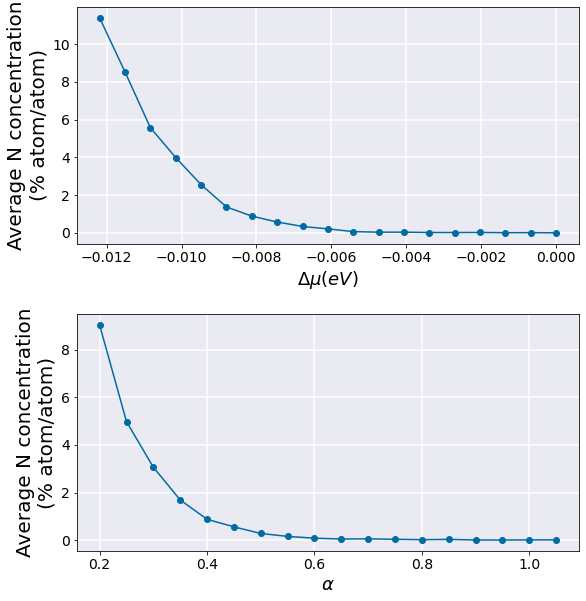

In [ ]:
for i in range(37):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/QA_g_mu_g_T_av_%s.csv'%i))

fig, axs = plt.subplots(2,1,figsize=(9, 10), sharex=False)

temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))

potential_fraction = chemical_potential_all[0:19]*Q_graphene_ml[0][0]
average_composition = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)*2)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    if j<19:
        
        for i in range(len(index_conc)-1):

            multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
            energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
        mu = np.round(potential_fraction[j],3)
        T = 1.0

        
    else:
        for s,i in enumerate(range(len(index_conc)-1)):

            multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
            energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

        T = temperature_range[j]


axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o-',label='$\Delta\mu$=%s'%(mu))
axs[1].plot(temperature_range[len(potential_fraction):],average_composition[len(potential_fraction):],
               'o-',label='$\Delta\mu$=%s'%(mu))

axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)
axs[0].tick_params(axis='x', labelsize=14)


axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('$\\alpha$',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)


axs[0].set_ylabel('Average N concentration\n(% atom/atom)',fontsize=20)
axs[1].set_ylabel('Average N concentration\n(% atom/atom)',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

axs[1].grid(color='white', linewidth=1.5)
axs[0].grid(color='white', linewidth=1.5)
axs[0].set_facecolor('#EAEAF2')

fig.subplots_adjust(hspace=0.3)

# fig.savefig('/Users/brunocamino/Desktop/graphene_av_potential_T.jpg',dpi=1000)

### Figure X1

#### Potential

In [ ]:
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []

temperature_range = [1.]*5 #Fig 1. all individual mu
chemical_potential_all = np.array([-0.4,-0.6,-0.7,-0.8,-0.9]) #Fig 1. all individual mu

potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]

potential_tmp = chemical_potential_all

bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):

    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)


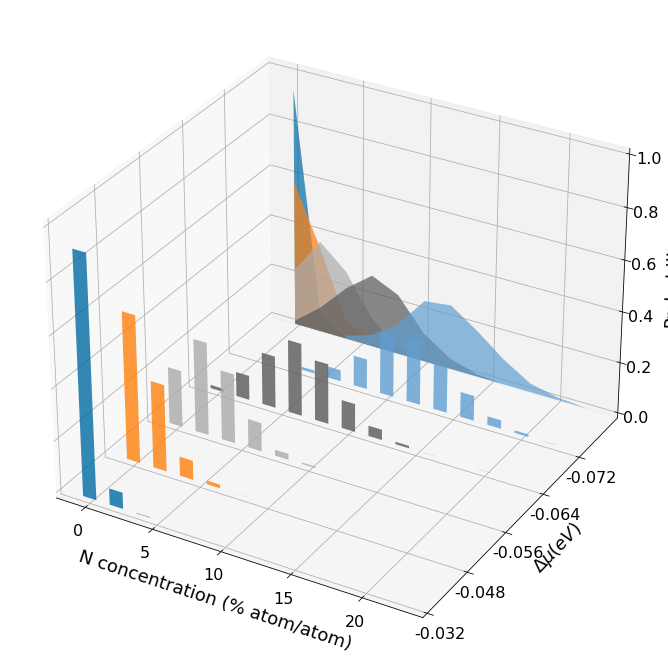

In [ ]:
df_list = []
for i in range(5):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/QA_g_mu_%s.csv'%i))
    
from matplotlib.collections import PolyCollection
#graph NEW 3D
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(projection='3d')

conc_all = []
prob_all = []

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
for j,ddf in enumerate(df_list):

    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)*2)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    for s,i in enumerate(range(len(index_conc)-1)):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

    conc_all.append(conc.tolist())
    prob_all.append((np.array(multiplicity_unique)/num_reads).tolist())
    T = temperature_range[j]
    axs.bar(conc*2,np.array(multiplicity_unique)/num_reads, zs=j,width=1.,
            alpha=0.8,zdir='y', label='$\\alpha$=%s'%(T))
    line = polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)

    verts = [polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)]

    poly = PolyCollection(verts,facecolors=colors[j], alpha=.7)

    axs.add_collection3d(poly, zs=len(df_list), zdir='y')

    
axs.set_xlabel('N concentration (% atom/atom)',fontsize=18)
axs.set_ylabel('$\Delta\mu (eV)$',fontsize=18,rotation=90)
axs.set_zlabel('Probability',fontsize=18,rotation=90)


custom_yticks = [0,1,2,3,4]
axs.set_yticks(custom_yticks)
axs.set_yticklabels([-0.032, -0.048, -0.056, -0.064, -0.072])
axs.tick_params(axis='x', labelsize=16)
axs.tick_params(axis='y', labelsize=16)
axs.tick_params(axis='z', labelsize=16)
axs.xaxis.labelpad = 10
axs.yaxis.labelpad = 10
axs.zaxis.labelpad = 10

axs.set_ylim([0,len(df_list)])
axs.set_zlim([0,1])

fig.savefig('/Users/brunocamino/Desktop/QA_g_mu.png',dpi=800)

### Figure X1

#### Temperature

In [ ]:
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []

temperature_range = [1.,0.35,0.3,0.25,0.2] #Fig 1. all individual temperature

chemical_potential_all = np.array([0.]*len(temperature_range)) #Fig 1. all individual temperature
potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]


potential_tmp = chemical_potential_all


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):


    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)

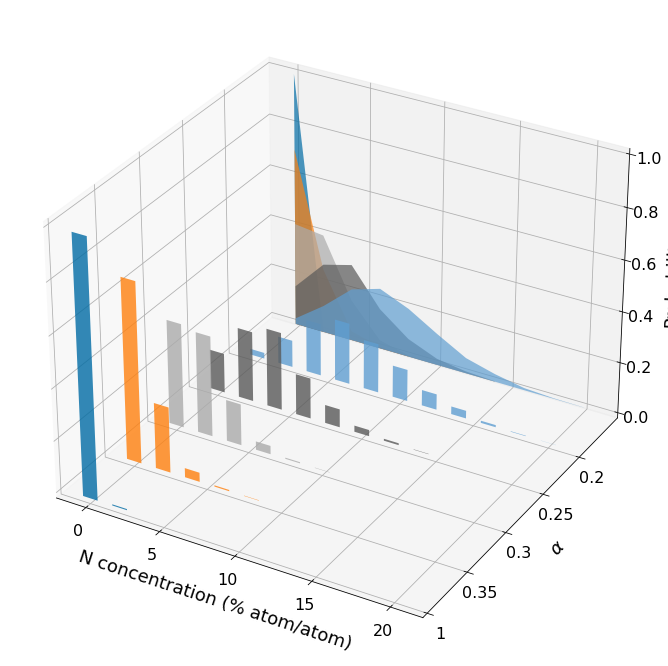

In [ ]:
df_list = []
for i in range(5):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/QA_g_T_%s.csv'%i))
    
from matplotlib.collections import PolyCollection
#graph NEW 3D
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(projection='3d')

conc_all = []
prob_all = []

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
for j,ddf in enumerate(df_list):

    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)*2)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    for s,i in enumerate(range(len(index_conc)-1)):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

    conc_all.append(conc.tolist())
    prob_all.append((np.array(multiplicity_unique)/num_reads).tolist())
    T = temperature_range[j]
    axs.bar(conc*2,np.array(multiplicity_unique)/num_reads, zs=j,width=1.,
            alpha=0.8,zdir='y', label='$\\alpha$=%s'%(T))
    line = polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)

    verts = [polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)]

    poly = PolyCollection(verts,facecolors=colors[j], alpha=.7)

    axs.add_collection3d(poly, zs=len(df_list), zdir='y')

    
axs.set_xlabel('N concentration (% atom/atom)',fontsize=18)
axs.set_ylabel('$\\alpha$',fontsize=18,rotation=90)
axs.set_zlabel('Probability',fontsize=18,rotation=90)


custom_yticks = [0,1,2,3,4]
axs.set_yticks(custom_yticks)
axs.set_yticklabels([1,0.35,0.30,0.25,0.2])
axs.tick_params(axis='x', labelsize=16)
axs.tick_params(axis='y', labelsize=16)
axs.tick_params(axis='z', labelsize=16)
axs.xaxis.labelpad = 10
axs.yaxis.labelpad = 10
axs.zaxis.labelpad = 10

axs.set_ylim([0,len(df_list)])
axs.set_zlim([0,1])

fig.savefig('/Users/brunocamino/Desktop/QA_g_T.png',dpi=800)

## Figure X2

In [ ]:
#KEEP THIS
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []


temperature_range = np.array([0.25,0.25,0.25,0.5,0.5,0.5,1.,1.,1.]) #Fig.2
chemical_potential_all = np.array([0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.72,-0.85])

potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):


    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)

In [ ]:
#mu_QUBO_all = np.array([0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.795,-0.85])*Q_graphene_ml[0][0]
mu_QUBO_all = np.array(potential_tmp)*Q_graphene_ml[0][0]
T_all = [355,350,350,160,160,160,50,50,50]
for i in range(9):
    unique_energies,probability_energy = get_qubo_probability(mu=mu_QUBO_all[i],temperature=T_all[i])
    np.savetxt('../quantum_computing/data/qa/QUBO_%s.csv'%i, probability_energy, delimiter=',')
np.savetxt('../quantum_computing/data/qa/unique_energy.csv', unique_energies, delimiter=',')

In [ ]:
mu_QUBO_all

array([ 0.        , -0.00406195, -0.00541593,  0.        , -0.0081239 ,
       -0.00947788,  0.        , -0.00974868, -0.01150886])

In [ ]:
np.savetxt('../quantum_computing/data/qa/unique_energy.csv', unique_energies, delimiter=',')

### I need to save the QUBO old to plot this

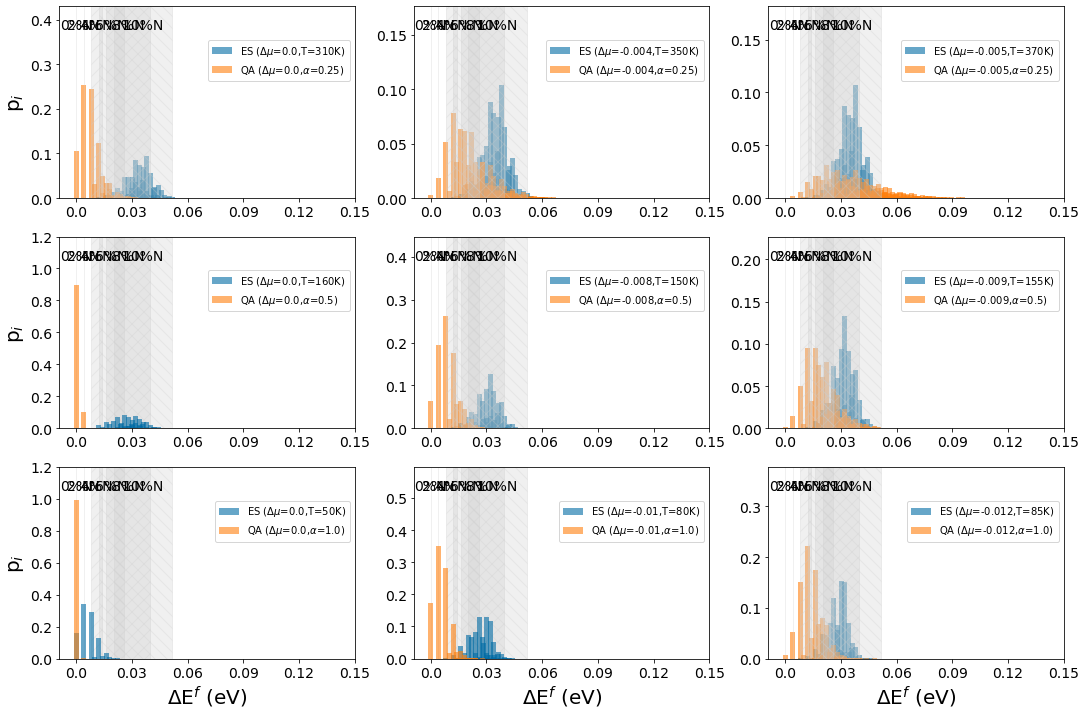

In [ ]:
temperature_range = [0.25,0.25,0.25,0.5,0.5,0.5,1.,1.,1.]
potential_tmp = np.array([0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.72,-0.85])
potential_fraction = potential_tmp*Q_graphene_ml[0][0]

fig, axs = plt.subplots(3,3,figsize=(18, 12), sharey=False,sharex=False)
T_all = [200,200,200,50,50,50,20,14,20]
T_all = [310,350,370,160,150,155,50,80,85]
# # EXHAUSTIVE SEARCH


shaded_areas_i = []
shaded_areas_f = []
for i in range(0,6):
    shaded_areas_i.append(np.min(np.array(graphene_allN_qubo_energy_list[i])))
    shaded_areas_f.append(np.max(np.array(graphene_allN_qubo_energy_list[i])))

df_list = []
for i in range(9):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/QA_graphene_mu_T_%s.csv'%i))
    
unique_energies = np.loadtxt('../quantum_computing/data/qa/unique_energy.csv', delimiter=",", dtype=float)

for j,ddf in enumerate(df_list):
    m = j%3
    n = int((j-m)/3)
    mu = np.round(potential_tmp[j]*Q_graphene_ml[0][0],3)
    # EXHAUSTIVE SEARCH
    
    
    unique_energies,probability_energy = get_qubo_probability(mu=potential_fraction[j],temperature=T_all[j])
    
#     unique_energies = np.loadtxt('../quantum_computing/data/qa/unique_energy.csv', delimiter=",", dtype=float)
#     probability_energy = np.loadtxt('../quantum_computing/data/qa/QUBO_%s.csv'%j, delimiter=",", dtype=float)
    
    zero_values = np.where(np.array(probability_energy) <0.00001)
    unique_energies = np.delete(unique_energies,zero_values)
    probability_energy = np.delete(probability_energy,zero_values)
    
    
    axs[n][m].bar(unique_energies,probability_energy,width=0.009,
                  alpha=0.6,label='ES ($\Delta\mu$=%s,T=%sK)'%(mu,T_all[j]))

    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    for config in configurations:
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
    
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

    
    index = np.unique(dddf.sort_values(by='energy')['energy'].to_numpy(),return_counts=True,return_index=True)[1]
    index = np.append(index,len(dddf))
    multiplicity = dddf.sort_values(by='energy')['num_occurrences'].to_numpy()

    energy = np.unique(dddf.sort_values(by='energy')['energy'].to_numpy())
    multiplicity_unique = []
    for i in range(len(index)-1):

        multiplicity_unique.append(np.sum(multiplicity[index[i]:index[i+1]]))

    #### PARTITION FUNCTION ####
    probability = (get_partition_function(energy,multiplicity_unique, T=298.15))[1]
    mu = np.round(potential_tmp[j]*Q_graphene_ml[0][0],3)
    T = temperature_range[j]

    axs[n][m].bar(energy,np.array(multiplicity_unique)/num_reads,width=0.009,
                alpha=0.6,label='QA ($\Delta\mu$=%s,$\\alpha$=%s)'%(mu,T))    

    
    axs[n][m].set_xlim([-0.03,shaded_areas_f[-1]])
    axs[n][m].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
    axs[n][m].set_xticklabels([0.  , 0.03, 0.06, 0.09, 0.12, 0.15]) #rescaling for new QUBO
    if m == 2:
        axs[m][n].set_xlabel('$\Delta$E$^{f}$ (eV)',fontsize=20) 
    if n == 0:
        axs[m][n].set_ylabel('p$_{i}$',fontsize=20)
    axs[m][n].tick_params(axis='x', labelsize=14)
    axs[m][n].tick_params(axis='y', labelsize=14)

    
    max_y = np.max([np.max(np.array(multiplicity_unique)/num_reads),np.max(probability_energy)])

    max_y = max_y + max_y*0.7
    if max_y > 1.:
        max_y = 1.2
    axs[n][m].set_ylim([0.,max_y])
    axs[n][m].legend(bbox_to_anchor=(1., 0.85),loc='upper right')
    
    colors = ['#CECECE','#DEDEDE']
    
    hatchs = ['//','\\\\']
    text = ['0%N','2%N','4%N','6%N','8%N','10%N','12%N','14%N']
    
    for k,h in enumerate(shaded_areas_i):
        axs[m][n].axvspan(shaded_areas_i[k], shaded_areas_f[k], color=colors[0], hatch=hatchs[k%2], alpha=0.3,)
        if n >-1:
            midpoint = (shaded_areas_i[k] + shaded_areas_f[k]) / 2
            axs[n][m].text(midpoint, max_y-0.1*max_y, text[k], ha='center', va='center', fontsize=14, color='black')#,fontweight='bold')

# fig.savefig('/Users/brunocamino/Desktop/graphene_QA_QUBO_T_mu',dpi=800)

# <a id='anneal_binary_gaaln'>Ga/AlN</a>


In [ ]:
# for i in range(len(df_list)):
#     df_list[i].to_csv('../quantum_computing/data/qa/GaAlN/new_Q/QA_gaaln_mu_av_alpha_0.5_%s.csv'%i,index=False)

#TEST DISTRIBUTION
# sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))
df_list = []
for k in np.arange(10):
    num_anneal = 1
    Q_interaction_binary = copy.deepcopy(Q_gaaln_ml)
    
    df_list_1 = []
    sampleset_all = []

    temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new (average)
    temperature_range = [1]

    # chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18)) #Fig 1. all new (average)
    # chemical_potential_all = np.round(np.linspace(-5.5,2.,10),5)
    chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
    # chemical_potential_all = np.round(np.array(spacing_norm),5)
    temperature_range = [1.]*len(chemical_potential_all)
    temperature = 1.
    potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

    potential_tmp = chemical_potential_all

    bqm_all = []
    scale_factor_list = [] 
    scaling_init =  4/Q_gaaln_ml[0][0]
    for i,mu in enumerate(chemical_potential_all):
#         print(k,i,mu)

    #     scaling = ( -4/(0.05738+chemical_potential_all[i]) )
    #     print(chemical_potential_all[i],0.05741+chemical_potential_all[i])
    #     print((-4*np.unique(np.round(Q_gaaln_ml,5))[0])/(0.05741+chemical_potential_all[i]))

        Q_binary = Q_interaction_binary 
        bqm = dimod.BQM(Q_binary, "BINARY")

        for linear in bqm.linear.keys():
            #print(linear,i,potential_tmp[i])
    #             bqm.set_linear(linear,+4+4*potential)
            bqm.set_linear(linear,+4+4*chemical_potential_all[i])
        #print(chemical_potential_all[i],4+4*chemical_potential_all[i])
    #         bqm.set_linear(linear,mu)

        J = []
        for j,quadratic in enumerate(bqm.quadratic.keys()):
            J.append(bqm.quadratic[quadratic])

        scaled_J = np.array(J)*scaling_init
    #     scaled_J = np.array(J)/np.abs(min(J))

        for j,quadratic in enumerate(bqm.quadratic.keys()):
            bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[j])

        bqm.scale(temperature)        
        bqm_all.append(bqm)
        #chain_strength = uniform_torque_compensation(bqm,prefactor=2.)
#         for n in range(num_anneal):
            
    #         print(n, bqm.linear[0])
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)#,chain_strength = chain_strength)
        sampleset_all.append(sampleset)
        ddf = sampleset.to_pandas_dataframe()
            
        if i == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
#             print(k,n,mu,len(df_tmp))
        
    df_tmp.to_csv('data/qa/GaAlN/test_distribution/QA_gaaln_%s.csv'%(k+10),index=False)
    df_list.append(df_tmp)
    #print(bqm)
    #df_tmp.to_csv('data/qa/QA_df_%s'%j)

#TEST NORMALISATION
num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_gaaln_ml)

df_list = []
df_list_1 = []
sampleset_all = []

temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new (average)
temperature_range = [1]

# chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18)) #Fig 1. all new (average)
# chemical_potential_all = np.round(np.linspace(-5.5,2.,10),5)
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
# chemical_potential_all = np.round(np.array(spacing_norm),5)
temperature_range = [1.]*len(chemical_potential_all)
temperature = 1.
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

potential_tmp = chemical_potential_all

bqm_all = []
scale_factor_list = [] 
scaling_init =  4/0.05738
for i,mu in enumerate(chemical_potential_all):
    
#     scaling = ( -4/(0.05738+chemical_potential_all[i]) )
#     print(chemical_potential_all[i],0.05741+chemical_potential_all[i])
#     print((-4*np.unique(np.round(Q_gaaln_ml,5))[0])/(0.05741+chemical_potential_all[i]))

    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_gaaln_ml, "BINARY")

    for linear in bqm.linear.keys():
        #print(linear,i,potential_tmp[i])
#             bqm.set_linear(linear,+4+4*potential)
        bqm.set_linear(linear,mu)
    #print(chemical_potential_all[i],4+4*chemical_potential_all[i])
#         bqm.set_linear(linear,mu)

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)*scaling_init
#     scaled_J = np.array(J)/np.abs(min(J))
    
#     print(mu*54/np.sum(scaled_J))#,mu*54,np.sum(scaled_J)*(mu*54/np.sum(scaled_J)))
#     print(scaled_J*np.abs(mu*54/np.sum(scaled_J)))
#     scaled_J = np.array(scaled_J)*(np.abs(mu*54/np.sum(scaled_J)))
    scaled_J *= 100
#     print(scaled_J)
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(temperature)        
    bqm_all.append(bqm)
    #chain_strength = uniform_torque_compensation(bqm,prefactor=2.)
    for n in range(num_anneal):
#         print(n, bqm.linear[0])
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)#,chain_strength = chain_strength)
        sampleset_all.append(sampleset)
        ddf = sampleset.to_pandas_dataframe()
        
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)
    #print(bqm)
    #df_tmp.to_csv('data/qa/QA_df_%s'%j)

## Test normalisation

#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-4,+4,50),5)
potential_fraction = np.round(np.linspace(-4,+4,50),5)

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('data/qa/GaAlN/test_normalisation/3/QA_gaaln_mu_av_alpha_1.0_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

#temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
#chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:54].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/54)
    std_conc.append(np.std(np.sum(configurations,axis=1)/54))

    min_conc.append(np.min(np.sum(configurations,axis=1))/54)
    max_conc.append(np.max(np.sum(configurations,axis=1))/54)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_gaaln_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),54,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/54,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/54,conc_mult/num_reads, alpha=0.3)
    
#     # Original color
#     original_color = '#006BA4'

#     # Convert hex to RGB
#     r, g, b = tuple(int(original_color[i:i+2], 16) / 255 for i in (1, 3, 5))

#     # Generate lighter shades
#     lighter_colors = [(r + (1 - r) * i, g + (1 - g) * i, b + (1 - b) * i) for i in 1-(conc_mult*100)/(num_reads)]
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/54,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ga ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

# df_list = []
# for i in range(len(chemical_potential_all)):
#     df_list.append(pd.read_csv('data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_%s.csv'%i))
# #     df_list.append(pd.read_csv('data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_alpha_0.1_%s.csv'%i))
df_all = copy.deepcopy(df_list[0])
for df in df_list:
    df_all = pd.concat([df_all, df], ignore_index=True)

config_all = df_all.iloc[:,0:54].to_numpy()
conc_all = np.sum(df_all.iloc[:,0:54].to_numpy(),axis=1)
conc_all_unique = np.unique(conc_all)
energies_all = []
test = []
#energies_unique_all = []
for config in config_all:
    energies_all.append(np.round(classical_energy(config,Q_gaaln_ml),5))
energies_all = np.array(energies_all)
for i,conc in enumerate(conc_all_unique):
    row_index = np.where(conc_all == conc)[0]
#     if i == 2:
#         test.append(config_all[row_index][np.unique(energies_all[row_index],return_index=True)[1]])
#         print(config_all[row_index][np.unique(energies_all[row_index],return_index=True)[1]])
#         print(energies_all[row_index][np.unique(energies_all[row_index],return_index=True)[1]]-
#              np.min(energies_all[row_index][np.unique(energies_all[row_index],return_index=True)[1]]))
    low_energy_index = (row_index[np.argsort(energies_all[row_index])[0]]) #0 for 1 and 1 for 1_excited
    #print(np.unique(energies_all[row_index]))
    plt.plot(np.array([i]*len(np.unique(energies_all[row_index])))/54,
             (np.unique(energies_all[row_index])-np.unique(energies_all[row_index])[0]),'o')
#     plt.plot(np.array([i]*len(np.unique(energies_all[row_index])))/54,
#              (np.unique(energies_all[row_index])-i*Q_gaaln_ml[0][0]),'o')
    
    plt.xlabel('Ga ratio',fontsize=16)
    plt.ylabel('Delta E',fontsize=16)
    
    gaaln_tmp = copy.deepcopy(aln_108_all)
    ga_index = np.where(config_all[low_energy_index]==1)[0]
    c = ((gan_bulk_mace.lattice.c*i+aln_bulk_mace.lattice.c*(54-i))/54)
    ab = ((gan_bulk_mace.lattice.a*i+aln_bulk_mace.lattice.a*(54-i))/54)
#     if i != 0 and i != 54:
    c *= 3
    ab *= 3
    atomic_numbers = np.array(gaaln_tmp.atomic_numbers)
    atomic_numbers[ga_index] = 31
    
    gaaln_tmp = Structure(Lattice.from_parameters(ab,ab,c,90,90,120),atomic_numbers,gaaln_tmp.frac_coords)
#     print(np.where(np.array(gaaln_tmp.atomic_numbers) == 31)[0])
#     for index in ga_index:
#         gaaln_tmp.replace(index,31)
#     CifWriter(gaaln_tmp).write_file('./data/crystal/GaAlN/mace/gap/1/GaAlN_{}.cif'.format(conc))

## New Q (alpha=1.0)

#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-0.9,-0.1,100),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('data/qa/GaAlN/new_Q/QA_gaaln_mu_av_alpha_0.5_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

#temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
#chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:54].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/54)
    std_conc.append(np.std(np.sum(configurations,axis=1)/54))

    min_conc.append(np.min(np.sum(configurations,axis=1))/54)
    max_conc.append(np.max(np.sum(configurations,axis=1))/54)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_gaaln_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),54,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/54,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/54,conc_mult/num_reads, alpha=0.3)
    
#     # Original color
#     original_color = '#006BA4'

#     # Convert hex to RGB
#     r, g, b = tuple(int(original_color[i:i+2], 16) / 255 for i in (1, 3, 5))

#     # Generate lighter shades
#     lighter_colors = [(r + (1 - r) * i, g + (1 - g) * i, b + (1 - b) * i) for i in 1-(conc_mult*100)/(num_reads)]
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/54,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ga ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

chemical_potential_all = np.round(np.linspace(-0.9,-0.1,100),5)

T_all = np.linspace(30,1000,100)
mae_all = []
for Ti in T_all:
    av_conc_classical = get_classical_av_conc(Q_gaaln_ml,
                          mu_range=np.round(np.linspace(-0.9,-0.1,100),5),T=Ti,size=10000)
    print(test_qubo_energies(av_conc_classical,average_composition))

T_all = np.linspace(40,140,100)
mae_all = []
for Ti in T_all:
    av_conc_classical = get_classical_av_conc(Q_gaaln_ml,
                          mu_range=np.round(np.linspace(-0.7,0.0005,50),5),T=Ti,size=10000)
    mae_all.append(test_qubo_energies(av_conc_classical,average_composition))
    print(test_qubo_energies(av_conc_classical,average_composition))

plt.plot(av_conc_classical)
plt.plot(average_composition)

## Average concentration vs chemical potential (alpha=1.0)

In [ ]:
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

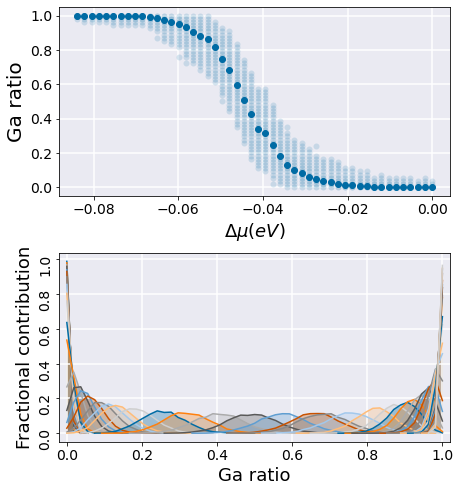

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

#temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
#chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:54].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/54)
    std_conc.append(np.std(np.sum(configurations,axis=1)/54))

    min_conc.append(np.min(np.sum(configurations,axis=1))/54)
    max_conc.append(np.max(np.sum(configurations,axis=1))/54)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_gaaln_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),54,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/54,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/54,conc_mult/num_reads, alpha=0.3)
    
#     # Original color
#     original_color = '#006BA4'

#     # Convert hex to RGB
#     r, g, b = tuple(int(original_color[i:i+2], 16) / 255 for i in (1, 3, 5))

#     # Generate lighter shades
#     lighter_colors = [(r + (1 - r) * i, g + (1 - g) * i, b + (1 - b) * i) for i in 1-(conc_mult*100)/(num_reads)]
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/54,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ga ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

## Average concentration vs chemical potential (alpha=0.5)

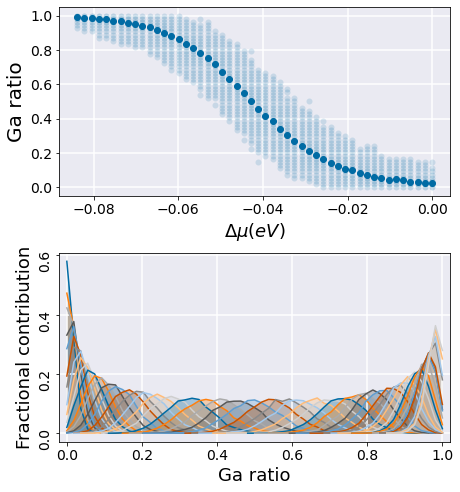

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_alpha_0.5_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

#temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
#chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:54].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/54)
    std_conc.append(np.std(np.sum(configurations,axis=1)/54))

    min_conc.append(np.min(np.sum(configurations,axis=1))/54)
    max_conc.append(np.max(np.sum(configurations,axis=1))/54)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_gaaln_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),54,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/54,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/54,conc_mult/num_reads, alpha=0.3)
    
#     # Original color
#     original_color = '#006BA4'

#     # Convert hex to RGB
#     r, g, b = tuple(int(original_color[i:i+2], 16) / 255 for i in (1, 3, 5))

#     # Generate lighter shades
#     lighter_colors = [(r + (1 - r) * i, g + (1 - g) * i, b + (1 - b) * i) for i in 1-(conc_mult*100)/(num_reads)]
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/54,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ga ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

# fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

### Read Band Gap

In [ ]:
E_gap_1 = []
E_1 = []
for i in range(55):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1/GaAlN_{}.out'.format(i))
    E_gap_1.append(crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1.append(energy_norm)

# E_1[0] = (E_aln - (E_al*54) )/54
# E_1[-1] = (E_gan - (E_ga*54) )/54
    
E_gap_1[0]  = 6.2643
E_gap_1[-1] = 3.7855

E_gap_1 = np.array(E_gap_1)
E_1 = np.array(E_1)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_1_exc = []
E_1_exc = []
state = 1
for i in range(2,53):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_excited/GaAlN_{}.out'.format(i))
    E_gap_1_exc.append(crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1_exc.append(energy_norm)

E_1_exc.insert(0,0.)
E_1_exc.insert(1,0.)
E_1_exc.append(0.)
E_1_exc.append(0.)

    
E_gap_1_exc.insert(0,E_gap_1[0])
E_gap_1_exc.insert(1,E_gap_1[1])
E_gap_1_exc.append(E_gap_1[-2])
E_gap_1_exc.append(E_gap_1[-1])

E_gap_1_exc = np.array(E_gap_1_exc)
E_1_exc = np.array(E_1_exc)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_1_exc_2 = []
E_1_exc_2 = []
for i in range(2,53):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_excited_2/GaAlN_{}.out'.format(i))
    E_gap_1_exc_2.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1_exc_2.append(energy_norm)

E_1_exc_2.insert(0,0.)
E_1_exc_2.insert(1,0.)
E_1_exc_2.append(0.)
E_1_exc_2.append(0.)

E_gap_1_exc_2.insert(0,E_gap_1[0])
E_gap_1_exc_2.insert(1,E_gap_1[1])
E_gap_1_exc_2.append(E_gap_1[-2])
E_gap_1_exc_2.append(E_gap_1[-1])
E_gap_1_exc_2 = np.array(E_gap_1_exc_2)
E_1_exc_2 = np.array(E_1_exc_2)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_1_exc_3 = []
for i in range(3,52):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_excited_3/GaAlN_{}.out'.format(i))
    E_gap_1_exc_3.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
E_gap_1_exc_3.insert(0,E_gap_1[0])
E_gap_1_exc_3.insert(1,E_gap_1[1])
E_gap_1_exc_3.insert(2,E_gap_1[2])
E_gap_1_exc_3.append(E_gap_1[-3])
E_gap_1_exc_3.append(E_gap_1[-2])
E_gap_1_exc_3.append(E_gap_1[-1])
E_gap_1_exc_3 = np.array(E_gap_1_exc_3)

In [ ]:
E_gap_1_exc_4 = []
for i in range(3,52):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_excited_4/GaAlN_{}.out'.format(i))
    E_gap_1_exc_4.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
E_gap_1_exc_4.insert(0,E_gap_1[0])
E_gap_1_exc_4.insert(1,E_gap_1[1])
E_gap_1_exc_4.insert(2,E_gap_1[2])
E_gap_1_exc_4.append(E_gap_1[-3])
E_gap_1_exc_4.append(E_gap_1[-2])
E_gap_1_exc_4.append(E_gap_1[-1])
E_gap_1_exc_4 = np.array(E_gap_1_exc_4)

In [ ]:
E_gap_1_max_p = []
for i in range(2,53):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_max_p/GaAlN_{}.out'.format(i))
    E_gap_1_max_p.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
E_gap_1_max_p.insert(0,E_gap_1[0])
E_gap_1_max_p.insert(1,E_gap_1[1])
# E_gap_1_max_p.insert(2,E_gap_1[2])
# E_gap_1_max_p.append(E_gap_1[-3])
E_gap_1_max_p.append(E_gap_1[-2])
E_gap_1_max_p.append(E_gap_1[-1])
E_gap_1_max_p = np.array(E_gap_1_max_p)

In [ ]:
E_gap_1_exc_last = []
E_1_exc_last = []
for i in range(3,52):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_excited_last/GaAlN_{}.out'.format(i))
    E_gap_1_exc_last.append(crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1_exc_last.append(energy_norm)
    
E_gap_1_exc_last.insert(0,E_gap_1[0])
E_gap_1_exc_last.insert(1,E_gap_1[1])
E_gap_1_exc_last.insert(2,E_gap_1[2])
E_gap_1_exc_last.append(E_gap_1[-3])
E_gap_1_exc_last.append(E_gap_1[-2])
E_gap_1_exc_last.append(E_gap_1[-1])

E_1_exc_last.insert(0,E_gap_1[0])
E_1_exc_last.insert(1,E_gap_1[1])
E_1_exc_last.insert(2,E_gap_1[2])
E_1_exc_last.append(E_gap_1[-3])
E_1_exc_last.append(E_gap_1[-2])
E_1_exc_last.append(E_gap_1[-1])

E_gap_1_exc_last = np.array(E_gap_1_exc_last)
E_1_exc_last = np.array(E_1_exc_last)

In [ ]:
E_gap_1_all = [E_gap_1,E_gap_1_exc,E_gap_1_exc_2,E_gap_1_exc_3,E_gap_1_exc_4,E_gap_1_max_p,E_gap_1_exc_last]
E_gap_1_all = np.array(E_gap_1_all)

## Grand canonical

In [ ]:
df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/GaAlN/new_Q/QA_gaaln_mu_av_alpha_0.5_%s.csv'%i))
#     df_list.append(pd.read_csv('../quantum_computing/data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_alpha_0.1_%s.csv'%i))
df_all = copy.deepcopy(df_list[0])
for df in df_list:
    df_all = pd.concat([df_all, df], ignore_index=True)

In [ ]:
config_all = df_all.iloc[:,0:54].to_numpy()
conc_all = np.sum(df_all.iloc[:,0:54].to_numpy(),axis=1)
conc_all_unique = np.unique(conc_all)
energies_all = []
for config in config_all:
    energies_all.append(np.round(classical_energy(config,Q_gaaln_ml),5))

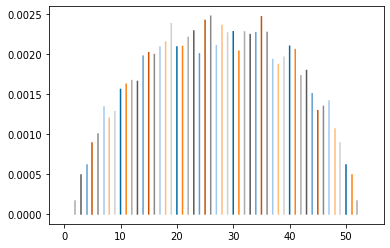

In [ ]:
energies_all = np.array(energies_all)
state = -1
slurm = []
unique_energies_all = []
unique_counts_all = []
for conc,i in enumerate(conc_all_unique):
    row_index = np.where(conc_all == conc)[0]
    unique_index = np.unique(energies_all[row_index], return_index=True)[1]
    plt.plot([i]*len(np.unique(energies_all[row_index])),(np.unique(energies_all[row_index])-np.min(energies_all[row_index]))/54)
    unique_energies, unique_counts = np.unique(energies_all[row_index],return_counts=True)
#     print(np.argmax(unique_counts))
    unique_energies_all.append(unique_energies)
    unique_counts_all.append(unique_counts)
    if len(unique_index) >= state+1:
        slurm.append('timeout 2437m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi_2 GaAlN_{} &'.format(conc))
    
#         print(row_index[unique_index],state)
#     print(conc,row_index[unique_index],energies_all[row_index][unique_index])

#         low_energy_index = (row_index[np.argsort(energies_all[row_index])[state]]) #0 for 1 and 1 for 1_excited
        low_energy_index =row_index[unique_index][np.argmax(unique_counts)]
        #print(low_energy_index)
#         print(config_all[low_energy_index])
#     if len(np.unique(energies_all[row_index])) > 1:
        #print(np.unique(energies_all[row_index])[0]-np.unique(energies_all[row_index])[1])#[1]-np.sort(energies_all[row_index])[0])
        gaaln_tmp = copy.deepcopy(aln_108_all)
        ga_index = np.where(config_all[low_energy_index]==1)[0]
#         for index in ga_index:
#             gaaln_tmp.replace(index,31)
#         CifWriter(gaaln_tmp).write_file('./../quantum_computing/data/crystal/GaAlN/mace/gap/1_max_p/GaAlN_{}.cif'.format(conc))

max_length = max(len(seq) for seq in unique_counts_all)

# Pad sequences with zeros to match the length of the longest sequence
unique_counts_all = np.array([np.pad(seq, (0, max_length - len(seq)), mode='constant') for seq in unique_counts_all])
unique_energies_all = np.array([np.pad(seq, (0, max_length - len(seq)), mode='constant') for seq in unique_energies_all])

#print(unique_energies_all)

In [ ]:
E_gap_gc_1 = []
for mu in range(len(conc_unique_all)):
    #print(conc_unique_all[mu])
    E_gap_gc_1.append(np.average(E_gap_1[conc_unique_all[mu]],weights=conc_mult_all[mu]))
    #E_gap_gc.append()

In [ ]:
states = 1
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
states = 2
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_2 = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_2.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
states = 3
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_3 = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_3.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
states = 4
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_4 = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_4.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
# THIS IS FOR THE MAX PROB ONLY
# states = 'max_p'
# E_gap_gc_1_max_p = []
# for mu in range(len(conc_unique_all)):
#     E_gap_gc_1_max_p.append(np.average(E_gap_1_max_p[conc_unique_all[mu]],weights=conc_mult_all[mu]))
    
states = 5
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_max_p = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_max_p.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
# THIS IS FOR THE LAST STATE ONLY
states = 'last'
E_gap_gc_1_exc_last_only = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_last_only.append(np.average(E_gap_1_exc_last[conc_unique_all[mu]],weights=conc_mult_all[mu]))

states = 6
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_last = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_last.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
E_gap_gc_all = [E_gap_gc_1,E_gap_gc_1_exc,E_gap_gc_1_exc_2,E_gap_gc_1_exc_3,
                E_gap_gc_1_exc_4,E_gap_gc_1_max_p,E_gap_gc_1_exc_last]

In [ ]:
E_gap_all = [E_gap_1,E_gap_1_exc,E_gap_1_exc_2,E_gap_1_exc_3,
             E_gap_1_exc_4,E_gap_1_max_p,E_gap_1_exc_last]
labels = ['Ground state','1st excited state','2nd excited state','3rd excited state',
          '4th excited state','max_p','last QUBO es']
for i,gap in enumerate(E_gap_gc_all):

    plt.plot(np.arange(4,51)/54,np.array(gap[3:52])-np.array(E_gap_gc_1[3:52]),'-',label=labels[i])
#     plt.plot(np.arange(1,54)/54,np.array(gap[3:52])-np.array(E_gap_1[3:52]),'-',label=labels[i])
plt.legend()
plt.xlabel('Ga Ratio',fontsize=14)
plt.ylabel('Delta E_g',fontsize=14)

ValueError: operands could not be broadcast together with shapes (49,) (47,) 

## Band gap plots

0


NameError: name 'E_gap_gc_5' is not defined

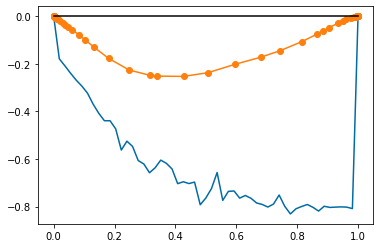

In [ ]:
fig, axs = plt.subplots(1, sharex=False)

x0 = 0
x1 = 1
y0 = E_gap[0]
y1 = E_gap[-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap-(np.arange(55)/54)*slope)[0]
axs.plot(np.arange(55)/54,(E_gap-(np.arange(55)/54)*slope)-yy1,'-',label='canonical')

for i in [0]:
    print(i)
    #average_composition = np.array(average_composition_all[i])
    x0 = average_composition[0]
    x1 = average_composition[-1]
    y0 = E_gap_gc_all[i][0]
    y1 = E_gap_gc_all[i][-1]
    slope = (y1-y0)/(x1-x0)
    #plt.plot(average_composition,average_composition*slope)
    yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
    axs.plot(average_composition,(E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1,'o-',label='gc (av)')
    #print((E_gap_gc_all[i]-average_composition*slope),y1)
axs.plot([0,1],[0,0],'k-')

axs.plot(average_composition,(E_gap_gc_5-np.array(average_composition)*slope)-yy1,'o-',label='gc (low E)')

axs.grid()
axs.grid(color='white', linewidth=1.5)

axs.set_facecolor('#EAEAF2')

axs.set_xlabel('Ga Ratio',fontsize=18)
axs.set_ylabel('E gap deviation\n from linearity (eV)',fontsize=16)

#axs.set_yticks(np.arange(4.6,6.5,0.3))
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.legend()
fig.savefig('/Users/brunocamino/Desktop/graphene_av_potential_T.jpg',dpi=1000)

#plt.plot(np.arange(55)/54,E_gap-(np.arange(55)/54)*slope-y0,'-')

In [ ]:
len(np.arange(3,52))

49

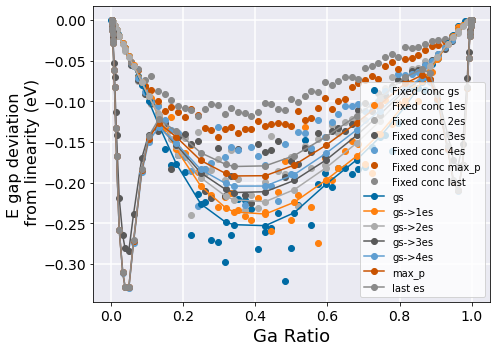

In [ ]:
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
fig, axs = plt.subplots(1, figsize=(7, 5),sharex=False)
E_gap_gc_all = [E_gap_gc_1,E_gap_gc_1_exc,E_gap_gc_1_exc_2,E_gap_gc_1_exc_3,
                E_gap_gc_1_exc_4,E_gap_gc_1_max_p,E_gap_gc_1_exc_last]
labels = ['gs','gs->1es','gs->2es','gs->3es','gs->4es','max_p','last es']
x0 = 0
x1 = 1
y0 = E_gap_1[0]
y1 = E_gap_1[-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_1-(np.arange(55)/54)*slope)[0]
axs.plot(np.arange(55)/54,(E_gap_1-(np.arange(55)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc gs')


axs.plot(np.arange(2,53)/54,(E_gap_1_exc[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[1],label='Fixed conc 1es')


axs.plot(np.arange(2,53)/54,(E_gap_1_exc_2[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[2],label='Fixed conc 2es')


axs.plot(np.arange(3,52)/54,(E_gap_1_exc_3[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[3],label='Fixed conc 3es')

axs.plot(np.arange(3,52)/54,(E_gap_1_exc_4[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[4],label='Fixed conc 4es')
axs.plot(np.arange(3,52)/54,(E_gap_1_max_p[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[5],label='Fixed conc max_p')
axs.plot(np.arange(3,52)/54,(E_gap_1_exc_last[3:-3]-(np.arange(3,52)/54)*slope)-yy1,
         'o',color=colors[6],label='Fixed conc last')

for i in [0,1,2,3,4,5,6]:
    x0 = average_composition[0]
    x1 = average_composition[-1]
    y0 = E_gap_gc_all[i][0]
    y1 = E_gap_gc_all[i][-1]
    slope = (y1-y0)/(x1-x0)

    yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
    axs.plot(average_composition,((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1),
             '-o',label=labels[i])


axs.grid()
axs.grid(color='white', linewidth=1.5)

axs.set_facecolor('#EAEAF2')

axs.set_xlabel('Ga Ratio',fontsize=18)
axs.set_ylabel('E gap deviation\n from linearity (eV)',fontsize=16)

axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.legend()
plt.tight_layout()
fig.savefig('/Users/brunocamino/Desktop/E_gap_deviation.jpg',dpi=1000,bbox_inches='tight')


In [ ]:
E_gap_gc_all

[[3.786006,
  3.78637517,
  3.78690542,
  3.7873353299999994,
  3.78819869,
  3.7886786399999997,
  3.7902165500000002,
  3.792282,
  3.79495337,
  3.7972763999999994,
  3.8047807099999997,
  3.81271916,
  3.84014312,
  3.86735737,
  3.8912693899999997,
  3.9211112,
  3.97259815,
  4.01161535,
  4.047247710000001,
  4.13481559,
  4.27337222,
  4.405143310000001,
  4.58617419,
  4.7685958500000005,
  4.951791410000001,
  5.167448549999999,
  5.228883799999999,
  5.42281049,
  5.639868700000001,
  5.808767950000001,
  5.90820554,
  5.97464722,
  6.053924179999999,
  6.098824590000001,
  6.13443822,
  6.1566569499999995,
  6.1900064100000005,
  6.2152791,
  6.2228648,
  6.23447822,
  6.23922367,
  6.24886771,
  6.24972966,
  6.253092230000001,
  6.25439505,
  6.25603779,
  6.2589143300000005,
  6.26069547,
  6.26095937,
  6.26207951],
 [3.7860060000000004,
  3.78637516165899,
  3.7869053699539377,
  3.7873352549309063,
  3.788198548202822,
  3.788678382653475,
  3.7902159292071205,
  3.79

In [ ]:
len(average_composition)

50

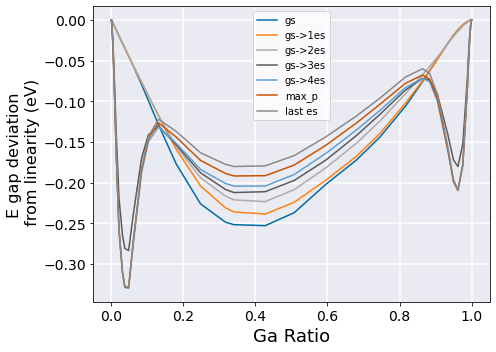

In [ ]:
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
fig, axs = plt.subplots(1, figsize=(7, 5),sharex=False)
E_gap_gc_all = [E_gap_gc_1,E_gap_gc_1_exc,E_gap_gc_1_exc_2,E_gap_gc_1_exc_3,
                E_gap_gc_1_exc_4,E_gap_gc_1_max_p,E_gap_gc_1_exc_last]
labels = ['gs','gs->1es','gs->2es','gs->3es','gs->4es','max_p','last es']
x0 = 0
x1 = 1
y0 = E_gap[0]
y1 = E_gap[-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap-(np.arange(55)/54)*slope)[0]
# axs.plot(np.arange(55)/54,(E_gap-(np.arange(55)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc gs')

# # x0 = 0
# # x1 = 1
# # y0 = E_gap_1_exc[0]
# # y1 = E_gap_1_exc[-1]
# # slope = (y1-y0)/(x1-x0)
# # yy1 = (E_gap_1_exc-(np.arange(55)/54)*slope)[0]
# axs.plot(np.arange(2,53)/54,(E_gap_1_exc[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[1],label='Fixed conc 1es')

# # x0 = 0
# # x1 = 1
# # y0 = E_gap_1_exc_2[0]
# # y1 = E_gap_1_exc_2[-1]
# # slope = (y1-y0)/(x1-x0)
# # yy1 = (E_gap_1_exc_2-(np.arange(len(E_gap_1_exc_2))/54)*slope)[0]
# axs.plot(np.arange(2,53)/54,(E_gap_1_exc_2[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[2],label='Fixed conc 2es')

# # x0 = 0
# # x1 = 1
# # y0 = E_gap_1_exc_3[0]
# # y1 = E_gap_1_exc_3[-1]
# # slope = (y1-y0)/(x1-x0)
# # yy1 = (E_gap_1_exc_3-(np.arange(len(E_gap_1_exc_3))/54)*slope)[0]
# axs.plot(np.arange(3,52)/54,(E_gap_1_exc_3[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[3],label='Fixed conc 3es')

# axs.plot(np.arange(3,52)/54,(E_gap_1_exc_4[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[4],label='Fixed conc 4es')
# axs.plot(np.arange(3,52)/54,(E_gap_1_max_p[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[5],label='Fixed conc max_p')
# axs.plot(np.arange(3,52)/54,(E_gap_1_exc_last[3:-3]-(np.arange(3,52)/54)*slope)-yy1,
#          'o',color=colors[6],label='Fixed conc last')



# Egx_formula = (fx+b[24]*average_composition*(1-average_composition))
# x0 = 0
# x1 = 1
# y0 = E_gap[0]
# y1 = E_gap[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap-(np.arange(55)/54)*slope)[0]
# #axs.plot(average_composition,b[24]*average_composition*(1-average_composition),'--',label='Test')
# #axs.plot(average_composition,-1.07*average_composition*(1-average_composition),'k--',label='Test')
# axs.plot(average_composition,-0.53*average_composition*(1-average_composition),'k--',label='Test')


for i in [0,1,2,3,4,5,6]:
    #print(i)
    #average_composition = np.array(average_composition_all[i])
    x0 = average_composition[0]
    x1 = average_composition[-1]
    y0 = E_gap_gc_all[i][0]
    y1 = E_gap_gc_all[i][-1]
    slope = (y1-y0)/(x1-x0)
    #plt.plot(average_composition,average_composition*slope)
    yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
#     axs.plot(average_composition,((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1),
#              '-',label=labels[i])#'Averaged 0-{}'.format(i))
    axs.plot(average_composition,((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1),
             '-',label=labels[i])
    #print((E_gap_gc_all[i]-average_composition*slope),y1)
    #print(np.round((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1,2))
# axs.plot([0,1],[0,0],'k-')

#axs.plot(average_composition,(E_gap_gc_5-np.array(average_composition)*slope)-yy1,'o-',label='gc (low E)')

axs.grid()
axs.grid(color='white', linewidth=1.5)

axs.set_facecolor('#EAEAF2')

axs.set_xlabel('Ga Ratio',fontsize=18)
axs.set_ylabel('E gap deviation\n from linearity (eV)',fontsize=16)

#axs.set_yticks(np.arange(4.6,6.5,0.3))
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.legend()
plt.tight_layout()
fig.savefig('/Users/brunocamino/Desktop/E_gap_deviation.jpg',dpi=1000,bbox_inches='tight')

#plt.plot(np.arange(55)/54,E_gap-(np.arange(55)/54)*slope-y0,'-')

In [ ]:
len(E_gap_gc_all[2])

50

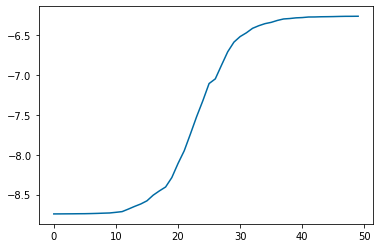

In [ ]:
plt.plot(np.array(average_composition)*slope-yy1)

In [ ]:
slope

-2.478221301794889

In [ ]:
x0 = average_composition[0]
x1 = average_composition[-1]
y0 = E_gap_gc_all[0][0]
y1 = E_gap_gc_all[0][-1]
slope = (y1-y0)/(x1-x0)
plt.plot(np.average(np.array(E_gap_gc_all)-np.array(average_composition)*slope-yy1,axis=0))



ValueError: operands could not be broadcast together with shapes (7,50) (55,) 

In [ ]:
yy1 = (E_gap_1-(np.arange(55)/54)*slope)

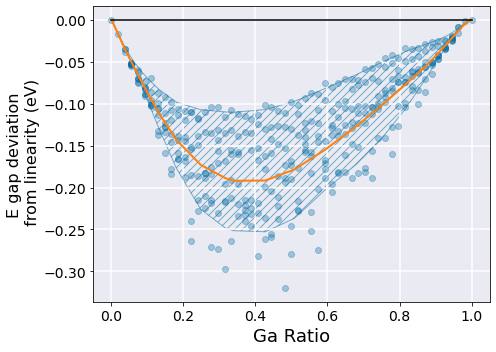

In [ ]:
#SAVE
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
colors = ['#006BA450', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
fig, axs = plt.subplots(1, figsize=(7, 5),sharex=False)
E_gap_gc_all = [E_gap_gc_1,E_gap_gc_1_exc,E_gap_gc_1_exc_2,E_gap_gc_1_exc_3,
                E_gap_gc_1_exc_4,E_gap_gc_1_max_p,E_gap_gc_1_exc_last]
labels = ['gs','gs->1es','gs->2es','gs->3es','gs->4es','max_p','last es']
x0 = 0
x1 = 1
y0 = E_gap_1[0]
y1 = E_gap_1[-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_1-(np.arange(55)/54)*slope)[0]
axs.plot(np.arange(55)/54,(E_gap_1-(np.arange(55)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc gs')

# x0 = 0
# x1 = 1
# y0 = E_gap_1_exc[0]
# y1 = E_gap_1_exc[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap_1_exc-(np.arange(55)/54)*slope)[0]
axs.plot(np.arange(2,53)/54,(E_gap_1_exc[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 1es')

# x0 = 0
# x1 = 1
# y0 = E_gap_1_exc_2[0]
# y1 = E_gap_1_exc_2[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap_1_exc_2-(np.arange(len(E_gap_1_exc_2))/54)*slope)[0]
axs.plot(np.arange(2,53)/54,(E_gap_1_exc_2[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 2es')

# x0 = 0
# x1 = 1
# y0 = E_gap_1_exc_3[0]
# y1 = E_gap_1_exc_3[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap_1_exc_3-(np.arange(len(E_gap_1_exc_3))/54)*slope)[0]
axs.plot(np.arange(3,52)/54,(E_gap_1_exc_3[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 3es')

axs.plot(np.arange(3,52)/54,(E_gap_1_exc_4[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 4es')
axs.plot(np.arange(3,52)/54,(E_gap_1_max_p[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc max_p')
axs.plot(np.arange(3,52)/54,(E_gap_1_exc_last[3:-3]-(np.arange(3,52)/54)*slope)-yy1,
         'o',color=colors[0],label='Fixed conc last')



# Egx_formula = (fx+b[24]*average_composition*(1-average_composition))
# x0 = 0
# x1 = 1
# y0 = E_gap[0]
# y1 = E_gap[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap-(np.arange(55)/54)*slope)[0]
# #axs.plot(average_composition,b[24]*average_composition*(1-average_composition),'--',label='Test')
# #axs.plot(average_composition,-1.07*average_composition*(1-average_composition),'k--',label='Test')
# axs.plot(average_composition,-0.53*average_composition*(1-average_composition),'k--',label='Test')


for i in [5]:
    #print(i)
    #average_composition = np.array(average_composition_all[i])
    x0 = average_composition[0]
    x1 = average_composition[-1]
    y0 = E_gap_gc_all[i][0]
    y1 = E_gap_gc_all[i][-1]
    slope = (y1-y0)/(x1-x0)
    #plt.plot(average_composition,average_composition*slope)
    yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
    axs.plot(average_composition,((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1),
             '-',color = colors[1],label=labels[i],linewidth=2)#'Averaged 0-{}'.format(i))
    #print((E_gap_gc_all[i]-average_composition*slope),y1)
    #print(np.round((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1,2))
axs.plot([0,1],[0,0],'k-')

# FILL BETWEEN

x0 = average_composition[0]
x1 = average_composition[-1]
y0 = E_gap_gc_all[i][0]
y1 = E_gap_gc_all[i][-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
top = ((E_gap_gc_1_exc_last_only-np.array(average_composition)*slope)-yy1)


x0 = average_composition[0]
x1 = average_composition[-1]
y0 = E_gap_gc_all[i][0]
y1 = E_gap_gc_all[i][-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
bottom = ((E_gap_gc_all[0]-np.array(average_composition)*slope)-yy1)

axs.fill_between(average_composition,top,bottom,hatch='///', edgecolor='#006BA450', facecolor='none', alpha=0.5)

#axs.plot(average_composition,(E_gap_gc_5-np.array(average_composition)*slope)-yy1,'o-',label='gc (low E)')

axs.grid()
axs.grid(color='white', linewidth=1.5)

axs.set_facecolor('#EAEAF2')

axs.set_xlabel('Ga Ratio',fontsize=18)
axs.set_ylabel('E gap deviation\n from linearity (eV)',fontsize=16)

#axs.set_yticks(np.arange(4.6,6.5,0.3))
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
# axs.legend()
plt.tight_layout()
axs.set_xlim([-0.05,1.05])
fig.savefig('/Users/brunocamino/Desktop/E_gap_deviation.jpg',dpi=1000,bbox_inches='tight')

#plt.plot(np.arange(55)/54,E_gap-(np.arange(55)/54)*slope-y0,'-')

### Calculate b (REMOVE?)

-3789.072249990167

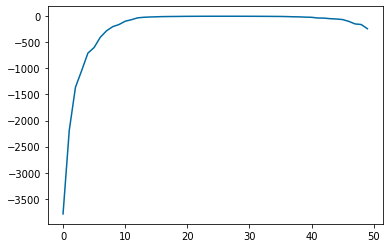

In [ ]:
E_gap_aln = E_gap[0]
E_gap_gan = E_gap[-1]

average_composition = np.array(average_composition)

coefficients = np.polyfit(average_composition, np.average(E_gap_gc_all,axis=0), 2)

# Create a polynomial function from the coefficients
quadratic_func = np.poly1d(coefficients)

# Generate points for plotting the quadratic curve
x_interpolated = average_composition
y_interpolated = quadratic_func(x_interpolated)
Egx = y_interpolated

fx = average_composition*E_gap_gan+(1-average_composition)*E_gap_aln

b = (Egx-fx)/(np.array(average_composition)*(1-np.array(average_composition)))
plt.plot(b)
index = np.argmin((b[1:]-b[0:-1])/(average_composition[1:]-average_composition[:-1]))
b[index]

In [ ]:
b

array([-3.78907225e+03, -2.19008063e+03, -1.36232885e+03, -1.04316213e+03,
       -7.09326581e+02, -6.01854104e+02, -4.04720161e+02, -2.81674779e+02,
       -2.01644201e+02, -1.61675455e+02, -9.82467345e+01, -6.90114240e+01,
       -3.38021633e+01, -2.21937289e+01, -1.70042758e+01, -1.31376550e+01,
       -9.50304042e+00, -7.92611376e+00, -6.92950506e+00, -5.40807997e+00,
       -4.20096236e+00, -3.58345610e+00, -3.08492732e+00, -2.77545870e+00,
       -2.60351081e+00, -2.51159407e+00, -2.50346984e+00, -2.53236399e+00,
       -2.68082412e+00, -2.94787892e+00, -3.24273037e+00, -3.56222749e+00,
       -4.22787965e+00, -4.90381273e+00, -5.77863538e+00, -6.62171911e+00,
       -8.83657731e+00, -1.25233619e+01, -1.45085570e+01, -1.95055551e+01,
       -2.28779200e+01, -3.61270429e+01, -3.81678333e+01, -4.91196888e+01,
       -5.53638383e+01, -6.60432751e+01, -1.00427742e+02, -1.49219617e+02,
       -1.60892847e+02, -2.41197845e+02])

### Read Band Gap (OLD?)

In [ ]:
E_gap = []
for i in range(55):
    crystal_output = Crystal_output().read_cry_output('./../quantum_computing/data/crystal/GaAlN/mace/gap/1/GaAlN_{}.out'.format(i))
    E_gap.append(crystal_output.get_band_gap())
    crystal_output_pmg = cry_gui2pmg(Crystal_gui().read_gui('./../quantum_computing/data/crystal/GaAlN/mace/gap/1/GaAlN_{}.gui'.format(i)))
E_gap = np.array(E_gap)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_gc_1 = []
for mu in range(len(conc_unique_all)):
    #print(conc_unique_all[mu])
    E_gap_gc_1.append(np.average(E_gap[conc_unique_all[mu]],weights=conc_mult_all[mu]))
    #E_gap_gc.append()

# <a id='anneal_binary_wmo'>TaW</a>


In [ ]:
# for i in range(len(df_list)):
#     df_list[i].to_csv('../quantum_computing/data/qa/TaW/QA_taw_mu_av_alpha_0.5_%s.csv'%i,index=False)

## TaW new Q (alpha=1.0)

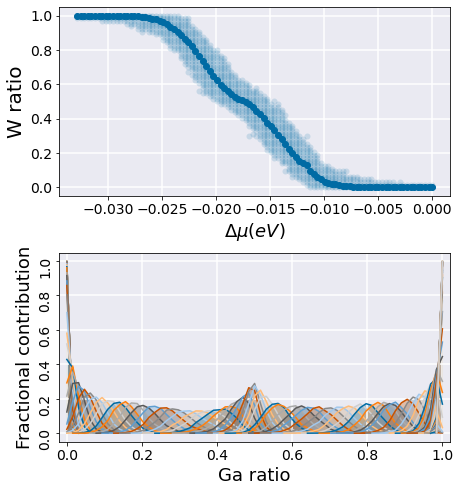

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-2.5,0.,100),5)
potential_fraction = chemical_potential_all*Q_taw_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/TaW/QA_taw_mu_av_alpha_1.0_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

#temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
#chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:64].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/64)
    std_conc.append(np.std(np.sum(configurations,axis=1)/64))

    min_conc.append(np.min(np.sum(configurations,axis=1))/64)
    max_conc.append(np.max(np.sum(configurations,axis=1))/64)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_taw_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),64,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/64,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/64,conc_mult/num_reads, alpha=0.3)
    
#     # Original color
#     original_color = '#006BA4'

#     # Convert hex to RGB
#     r, g, b = tuple(int(original_color[i:i+2], 16) / 255 for i in (1, 3, 5))

#     # Generate lighter shades
#     lighter_colors = [(r + (1 - r) * i, g + (1 - g) * i, b + (1 - b) * i) for i in 1-(conc_mult*100)/(num_reads)]
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/64,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('W ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

## TaW new Q (alpha=0.5)

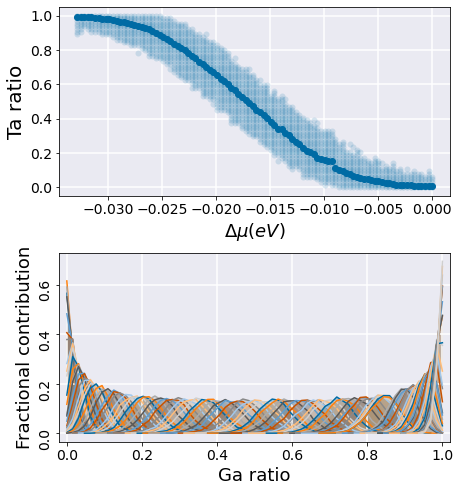

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-2.5,0.,100),5)
potential_fraction = chemical_potential_all*Q_taw_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('../quantum_computing/data/qa/TaW/QA_taw_mu_av_alpha_0.5_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:64].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/64)
    std_conc.append(np.std(np.sum(configurations,axis=1)/64))

    min_conc.append(np.min(np.sum(configurations,axis=1))/64)
    max_conc.append(np.max(np.sum(configurations,axis=1))/64)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_taw_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),64,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/64,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/64,conc_mult/num_reads, alpha=0.3)
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/64,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ta ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')

fig.subplots_adjust(hspace=0.3)

# fig.savefig('/Users/brunocamino/Desktop/TaW_average_conc.jpg',dpi=1000)

## Elastic constant

In [ ]:
df_all = copy.deepcopy(df_list[0])
for df in df_list:
    df_all = pd.concat([df_all, df], ignore_index=True)

# Elastic modulus

def extract_elastic_moduli(lines):
    # Find the start of the elastic moduli table
    start_idx = -1
    for i, line in enumerate(lines):
        if re.search(r'TOTAL ELASTIC MODULI \(kBar\)', line):
            start_idx = i
            break
    if start_idx == -1:
        raise ValueError("Elastic moduli section not found in the lines.")
    
    # Skip the first two lines (header and separator)
    data_lines = lines[start_idx+3:]
    
    matrix = []
    for line in data_lines:
        if re.match(r'\s*[-]+', line):  # Stop at the ending separator
            break
        # Split each line by spaces and filter out the first element (the direction label)
        values = list(map(float, line.split()[1:]))
        matrix.append(values)
    
    # Convert to a NumPy array
    return np.array(matrix)

#### Experimental

Text(0.5, 1.0, 'Experimental C11')

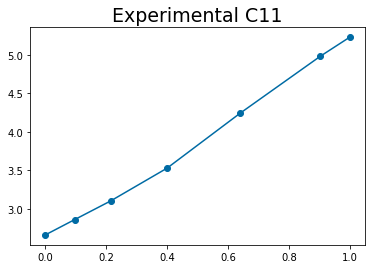

In [ ]:
W_conc_exp = np.array([0.,9.6,21.5,40.0,64.,90.4,100])/100
C11_exp = [2.6600,2.8579,3.1018,3.5267,4.240,4.9812,5.2269]
plt.plot(W_conc_exp,C11_exp,'o-')
plt.title('Experimental C11',fontsize=19)

Text(0.5, 1.0, 'Experimental C44')

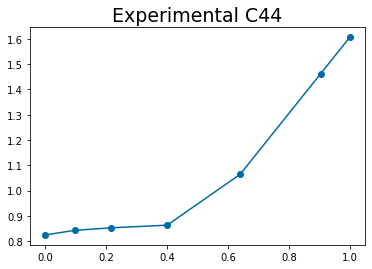

In [ ]:
W_conc_exp = np.array([0.,9.6,21.5,40.0,64.,90.4,100])/100
C44_exp = [0.8247,0.8427,0.8527,0.8632,1.0645,1.4614,1.6060]
plt.plot(W_conc_exp,C44_exp,'o-')
plt.title('Experimental C44',fontsize=19)

Text(0.5, 1.0, 'Experimental Bulk Modulus')

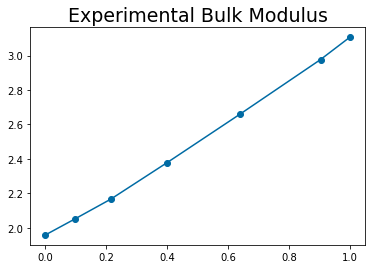

In [ ]:
W_conc_exp = np.array([0.,9.6,21.5,40.0,64.,90.4,100])/100
K_exp = [1.9596,2.0514,2.1673,2.3791,2.6608,2.9767,3.1060]
plt.plot(W_conc_exp,K_exp,'o-')
plt.title('Experimental Bulk Modulus',fontsize=19)

In [ ]:
from pymatgen.io.vasp import Poscar
from pymatgen.core import Structure

state = 1  # or whatever value state should have
folder = ['ground','1_excited_state']
structures = []

for i in range(0, 65):
    file_name = '../quantum_computing/data/vasp/TaW/elastic/{}/elastic/TaW_{}_{}.poscar'.format(folder[state],i, state)
    try:
        poscar = Poscar.from_file(file_name)
        structure = poscar.structure
        structures.append(structure)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")


In [ ]:
from pymatgen.io.vasp import Poscar
# check composition
state = '0'

for i in range(1,65):
    file_name = Structure.from_file('../quantum_computing/data/vasp/TaW/elastic/ground/elastic/TaW_{}_{}.poscar'.format(i,state),fmt="poscar")

ValueError: Unrecognized extension in filename='data/vasp/TaW/elastic/ground/elastic/TaW_1_0.poscar'

In [ ]:
state = '0'
elastic_moduli_all_g = []
for i in range(65):
    file_name = 'TaW_{}_{}.outcar'.format(i,state)
    with open('../quantum_computing/data/vasp/TaW/elastic/ground/elastic/{}'.format(file_name)) as f:
        text = f.readlines()
    elastic_moduli_all_g.append(extract_elastic_moduli(text))
elastic_moduli_all_g = np.array(elastic_moduli_all_g)

In [ ]:
state = '1'
elastic_moduli_all_1 = []
for i in range(65):
    file_name = 'TaW_{}_{}.outcar'.format(i,state)
    with open('../quantum_computing/data/vasp/TaW/elastic/1_excited_state/elastic/{}'.format(file_name)) as f:
        text = f.readlines()
    elastic_moduli_all_1.append(extract_elastic_moduli(text))
elastic_moduli_all_1 = np.array(elastic_moduli_all_1)

In [ ]:
C11_all = []
C44_all = []
C12_all = []
for i in range(65):
    C11_g = np.average([elastic_moduli_all_g[i,0,0],elastic_moduli_all_g[i,1,1],elastic_moduli_all_g[i,2,2]])
    C44_g = np.average([elastic_moduli_all_g[i,3,3],elastic_moduli_all_g[i,4,4],elastic_moduli_all_g[i,5,5]])
    C12_g = np.average([elastic_moduli_all_g[i,0,1],elastic_moduli_all_g[i,0,2],
            elastic_moduli_all_g[i,1,0],elastic_moduli_all_g[i,1,2],
            elastic_moduli_all_g[i,2,0],elastic_moduli_all_g[i,2,1]])
    
    C11_1 = np.average([elastic_moduli_all_1[i,0,0],elastic_moduli_all_1[i,1,1],elastic_moduli_all_1[i,2,2]])
    C44_1 = np.average([elastic_moduli_all_1[i,3,3],elastic_moduli_all_1[i,4,4],elastic_moduli_all_1[i,5,5]])
    C12_1 = np.average([elastic_moduli_all_1[i,0,1],elastic_moduli_all_1[i,0,2],
            elastic_moduli_all_1[i,1,0],elastic_moduli_all_1[i,1,2],
            elastic_moduli_all_1[i,2,0],elastic_moduli_all_1[i,2,1]])
    
    C11_all.append(np.average([C11_g,C11_1]))
    C44_all.append(np.average([C44_g,C44_1]))
    C12_all.append(np.average([C12_g,C12_1]))

C11_all = np.array(C11_all)
C44_all = np.array(C44_all)
C12_all = np.array(C12_all)
K = np.sum([C11_all,2*C12_all],axis=0)/3

Text(0.5, 1.0, 'C11')

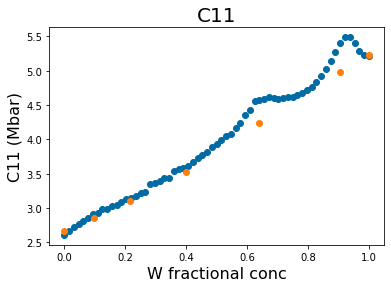

In [ ]:
plt.plot(np.arange(65)/64,C11_all/1000,'o')

plt.plot(W_conc_exp,C11_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C11 (Mbar)',fontsize=16)
plt.title('C11',fontsize=20)

Text(0.5, 1.0, 'C44')

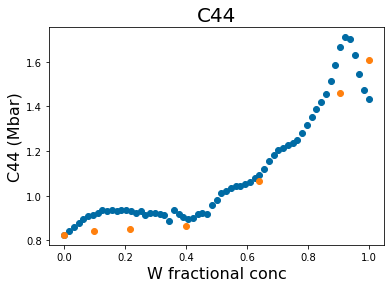

In [ ]:
shift = (C44_all[0])/1000- C44_exp[0]
# shift=0
plt.plot(np.arange(65)/64,(C44_all/1000)-shift,'o')

plt.plot(W_conc_exp,C44_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C44 (Mbar)',fontsize=16)
plt.title('C44',fontsize=20)

### Grand canonical

In [ ]:
C11_gc = []
for mu in range(len(conc_unique_all)):
    C11_gc.append(np.average(C11_all[conc_unique_all[mu]],weights=conc_mult_all[mu]))
C11_gc = np.array(C11_gc)

In [ ]:
C44_gc = []
for mu in range(len(conc_unique_all)):
    C44_gc.append(np.average(C44_all[conc_unique_all[mu]],weights=conc_mult_all[mu]))
C44_gc = np.array(C44_gc)

In [ ]:
K_gc = []
for mu in range(len(conc_unique_all)):
    K_gc.append(np.average(K[conc_unique_all[mu]],weights=conc_mult_all[mu]))
K_gc = np.array(K_gc)

shift=  0


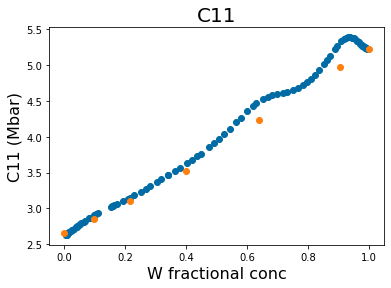

In [ ]:
shift = np.average([(C11_all[0]/1000- C11_exp[0]),(C11_all[-1]/1000- C11_exp[-1])])
shift = (C11_all[0]/1000- C11_exp[0])
shift = 0
plt.plot(average_composition,C11_gc/1000-shift,'o')
# plt.plot(np.arange(65)/64,C11_all/1000,'o')
plt.plot(W_conc_exp,C11_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C11 (Mbar)',fontsize=16)
plt.title('C11',fontsize=20)
print('shift= ', round(shift,4))

shift=  0


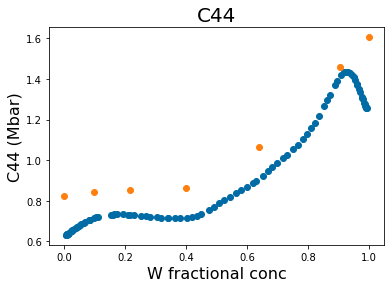

In [ ]:
shift = np.average([(C44_all[0]/1000- C44_exp[0]),(C44_all[-1]/1000- C44_exp[-1])])
shift = (C44_all[0]/1000- C44_exp[0])
shift = 0
plt.plot(average_composition,(C44_gc/1000)-shift,'o')
# plt.plot(np.arange(65)/64,C11_all/1000,'o')
plt.plot(W_conc_exp,C44_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C44 (Mbar)',fontsize=16)
plt.title('C44',fontsize=20)
print('shift= ', round(shift,4))

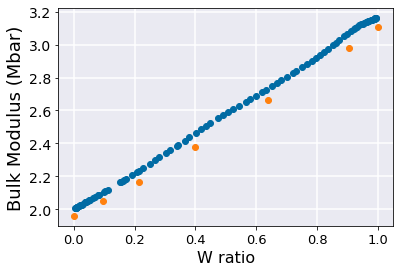

In [ ]:
fig, axs = plt.subplots(1, sharex=False)
# shift = np.average([(K[0]/1000- K_exp[0]),(K[-1]/1000- K_exp[-1])])
# shift = (K[0])/1000- K_exp[0]
shift = 0
axs.plot(average_composition,(K_gc/1000)-shift,'o')
# axs.plot(np.linspace(0,1,65),(K/1000)-shift,'o',color='k')
# plt.plot(np.arange(65)/64,C11_all/1000,'o')
axs.plot(W_conc_exp,K_exp,'o')
axs.set_xlabel('W ratio',fontsize=16)
axs.set_ylabel('Bulk Modulus (Mbar)',fontsize=18)
# axs.set_title('Bulk Modulus',fontsize=20)

axs.grid()
axs.grid(color='white', linewidth=1.5)
axs.tick_params(axis='x', labelsize=13)
axs.tick_params(axis='y', labelsize=14)
axs.set_facecolor('#EAEAF2')

# axs.set_xlabel('Ga Ratio',fontsize=18)
# axs.set_ylabel('E gap (eV)',fontsize=18)

# plt.grid(color='white', linewidth=1.5,zorder=0)
# plt.grid(color='white', linewidth=1.5,zorder=0)
# plt.facecolor('#EAEAF2')

fig.savefig('/Users/brunocamino/Desktop/bulk_modulus.jpg',dpi=1000)